In [859]:
#Import necessary libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [860]:
#import housing csv and convert to dataframe
df = pd.read_csv('Housing.csv')
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [861]:
print(f'The housing dataframe has {df.shape[0]} rows and {df.shape[1]} columns')

The housing dataframe has 545 rows and 13 columns


In [862]:
#display information about housing dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


There are 2 continuous variables and 4 discrete variables, and 7 categorical variables

In [863]:
#these columns will be converted into a category column for plotting 
categorical_columns = df.iloc[:, 2:].columns.to_list()
print(categorical_columns)
df[categorical_columns] = df[categorical_columns].astype('category')


['bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


In [864]:
print('Percentage of missing values per columns:', '\n', df.isnull().sum()/len(df))   

Percentage of missing values per columns: 
 price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64


No missing values for all columns

In [865]:
print('The number of unique values per column:', '\n', df.nunique())

The number of unique values per column: 
 price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64


In [866]:
print('Descriptive Statistics for each column for columns that are integers floats:', '\n', df.describe().T)

Descriptive Statistics for each column for columns that are integers floats: 
        count          mean           std        min        25%        50%  \
price  545.0  4.766729e+06  1.870440e+06  1750000.0  3430000.0  4340000.0   
area   545.0  5.150541e+03  2.170141e+03     1650.0     3600.0     4600.0   

             75%         max  
price  5740000.0  13300000.0  
area      6360.0     16200.0  


## Univariate Analysis

In [867]:
#creates a function that plots a histogram and boxplot of column along with some information about outliers
def plot_hist_and_box(data, column , size):
    plt.figure(figsize = size)
    #Creates a histogram for column of interest
    plt.subplot(1,2,1)
    sns.histplot(data = df, x = column)
    plt.title(f'Histogram of {column}')
    #Creates a boxplot for column of interest
    plt.subplot(1,2,2)
    sns.boxplot(data = df, x = column)
    plt.title(f'Boxplot of {column}')
    plt.show()
    #performs iqr by extracting 75% quartile value and the 25% quartile value and then subtracting by each other
    iqr = data[column].quantile(.75) - data[column].quantile(.25)
    #Extracts outliers from column of interest by obtaining obersvations that are either less than (25% - 1.5*iqr) or higher than (75% - 1.5*iqr)
    filter_outliers = data.loc[(data[column]< data[column].quantile(.25) - 1.5 * iqr) | (data[column] > data[column].quantile(.75) + 1.5 * iqr)]
    print(f'Number of outliers for {column} based on IQR:', len(filter_outliers))
    print('Percentage of outliers out of all the data based on IQR:', round(len(filter_outliers)/len(data),3))
    print(f'For column {column}, values over {data[column].quantile(.75) + 1.5*iqr} are considered outliers')
    print(f'For column {column}, values under {data[column].quantile(.25) - (1.5*iqr)} are considered outliers')

#Creates a function that plots a counplot that displays the number observations per class for that column and 
#another plot that displays the percentage of observations per class for that column
def plot_countplot(data , column, size):
    plt.figure(figsize=size)
    #displays a countplot with labels displaying number of observation per class
    plt.subplot(1,2,1)
    ax = sns.countplot(data = data, x = column)
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f'Countplot of {column}')

    plt.subplot(1,2,2)
    #creates a dataframe that displays the percentage of observations per class for column of interest
    normalized_grouped_column = round(data[column].value_counts(normalize = True),3).reset_index(name = 'percentage')
    #renames column 'index' to the column of interest's name in the dataframe
    normalized_grouped_column.rename(columns = {'index': column}, inplace = True)
    #plots dataframe that displays percentage of observations per class for column of interest as a barplot(countplot)
    #with percenatages as labels
    ax = sns.barplot(data=normalized_grouped_column, x = column, y = 'percentage')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f'Normalized countplot of {column}')
    plt.show()
    


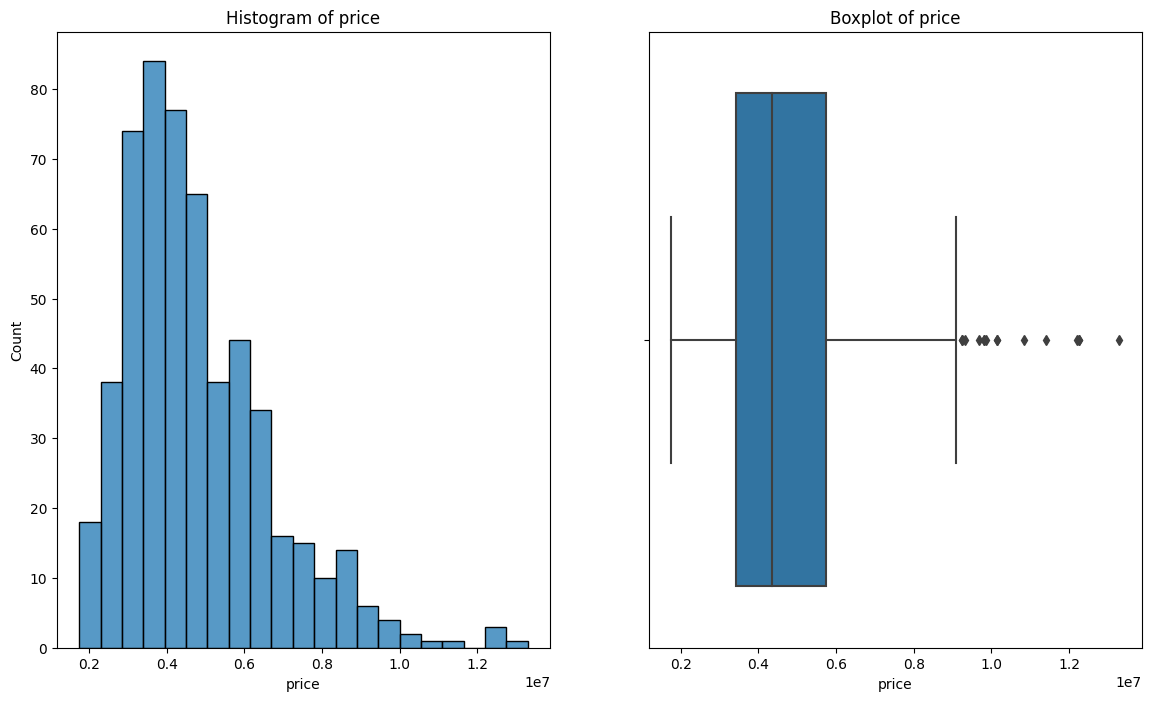

Number of outliers for price based on IQR: 15
Percentage of outliers out of all the data based on IQR: 0.028
For column price, values over 9205000.0 are considered outliers
For column price, values under -35000.0 are considered outliers


In [868]:
#displays histogram, boxplot and outlier information for price column 
plot_hist_and_box(data=df, column = 'price', size = (14,8))

- The distribution for price is skewed to the right
- large extreme price values pull the mean to be higher than the median
- Prices over $9,205,000 are considered outliers
- There are 15 homes that are above $9,205,000 
- price outliers that are considered extremely low is not possible

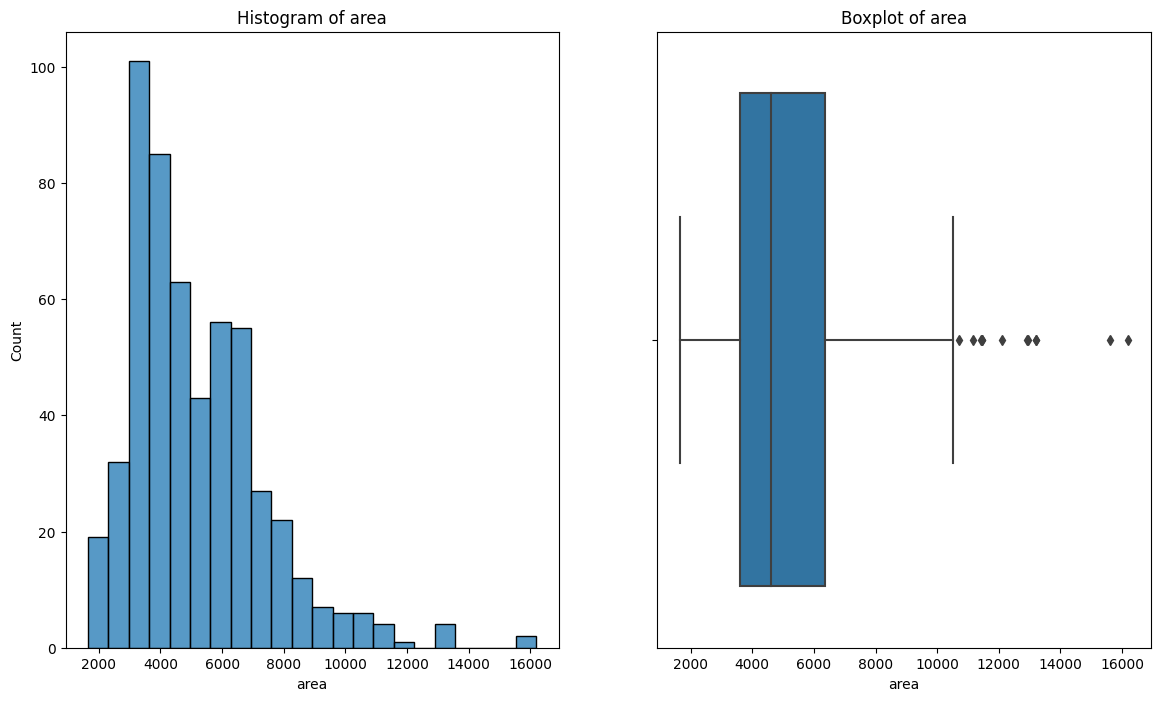

Number of outliers for area based on IQR: 12
Percentage of outliers out of all the data based on IQR: 0.022
For column area, values over 10500.0 are considered outliers
For column area, values under -540.0 are considered outliers


In [869]:
#displays histogram, boxplot and outlier information for area column 
plot_hist_and_box(data = df, column = 'area', size = (14,8))

- The distribution of area is skewed to the right as well, indicating that there are extremely large area values that skew the average area to be higher than the median area
- Any home above 10,500 sq ft is considered an outlier

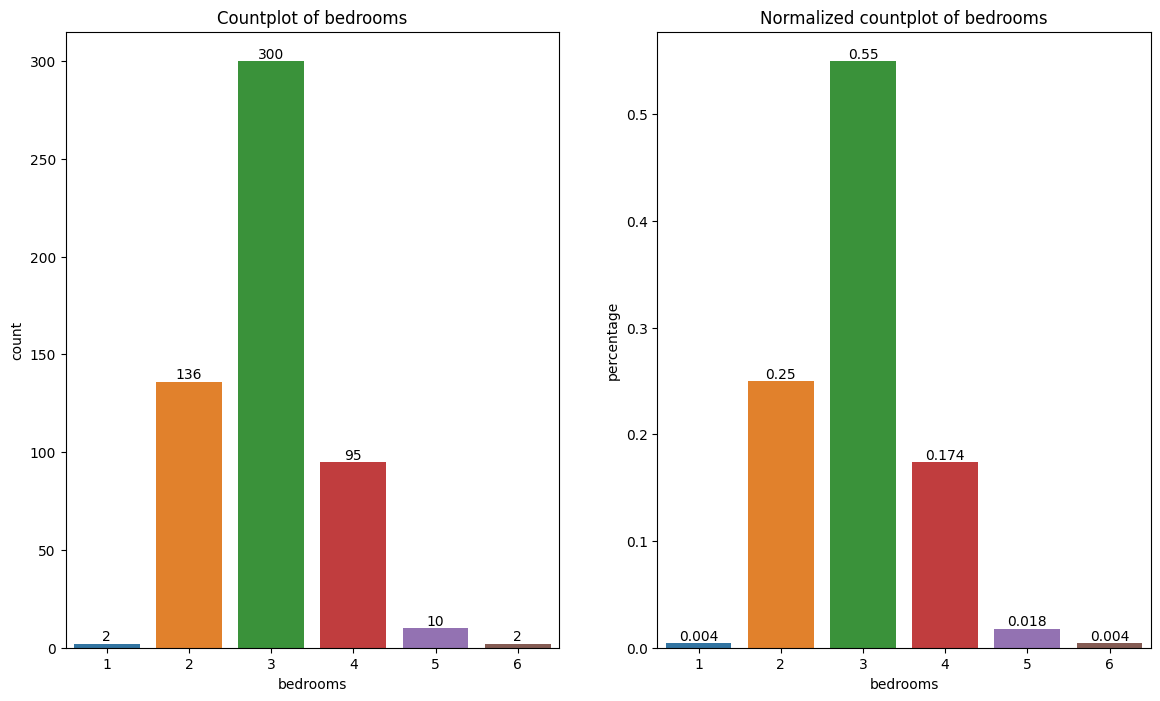

In [870]:
#displays a countplot and a normalized countplot for bedrooms column 
plot_countplot(data = df, column='bedrooms', size = (14,8))

- A 3 bedroom house is the most common number of bedrooms, accounts for over half of the homes in this dataset
- 1,5,6 bedroom homes account for way less than 1% of the homes in this dataset
 

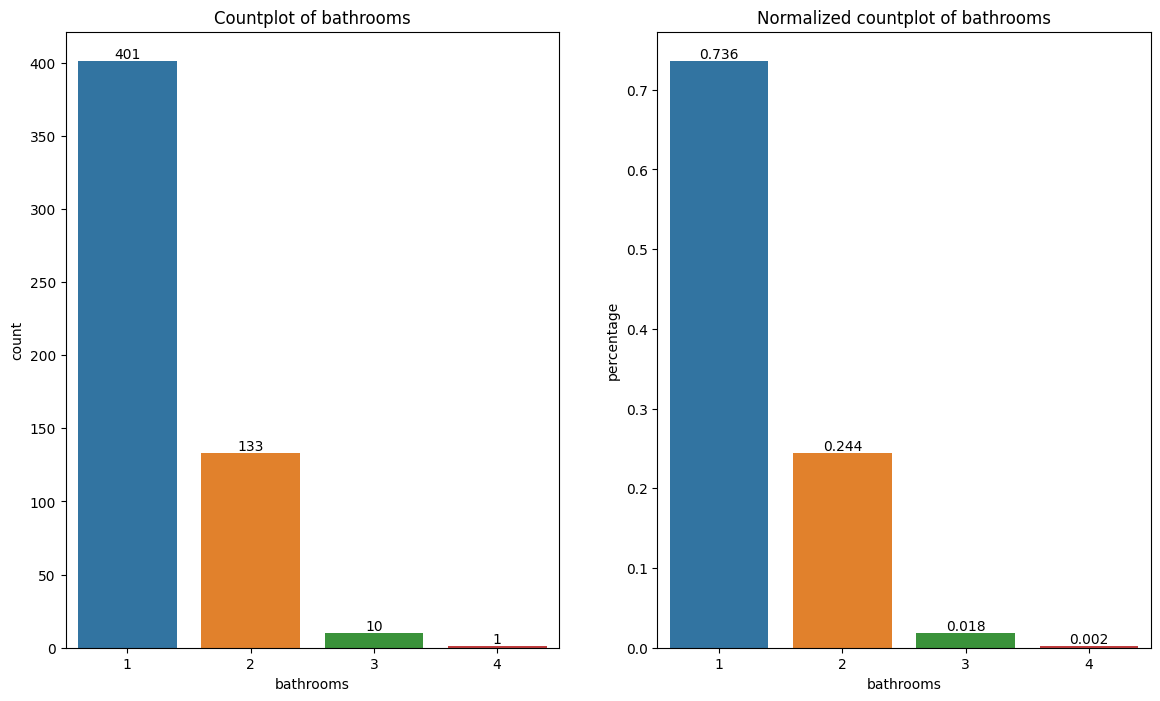

In [871]:
#displays a countplot and a normalized countplot for bathrooms column 
plot_countplot(data = df, column='bathrooms', size = (14,8))

- Majority of the homes in this dataset contain only 1 bathroom 
- The least common amount of bathrooms are 3 and 4
- about 99% of the number of bathrooms are either 1 or 2

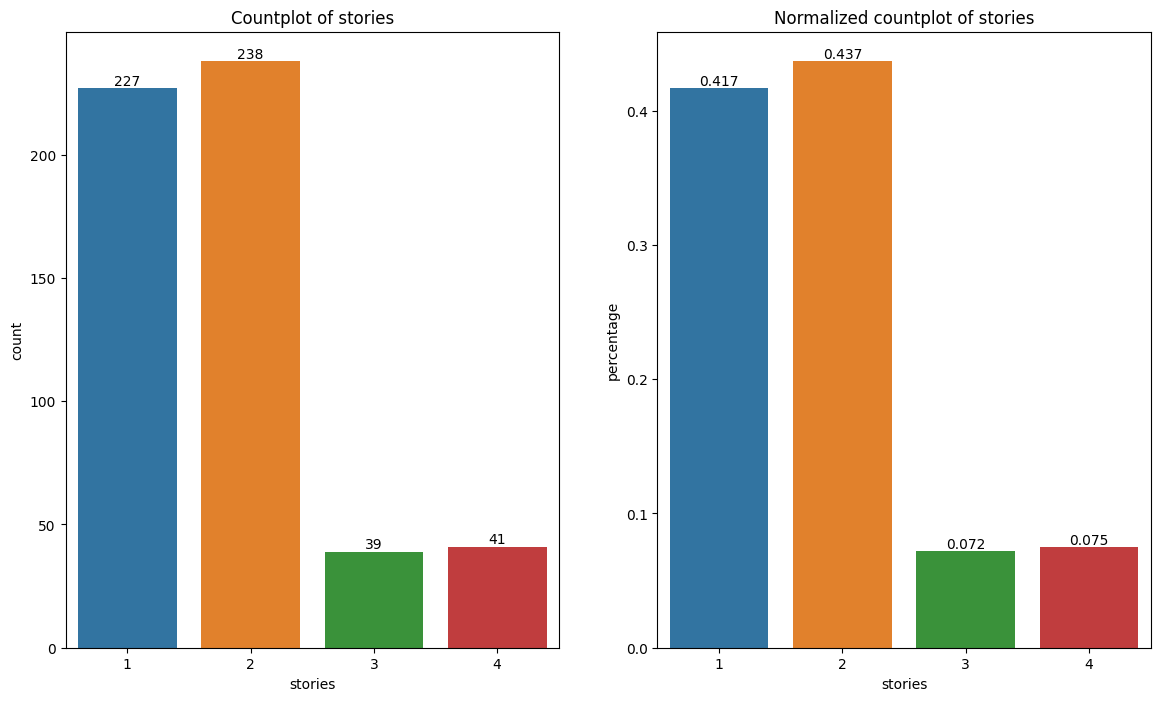

In [872]:
#displays a countplot and a normalized countplot for stories column 
plot_countplot(data = df, column='stories', size = (14,8))

- Majority of the homes in the dataset are either 1 or 2 stories tall


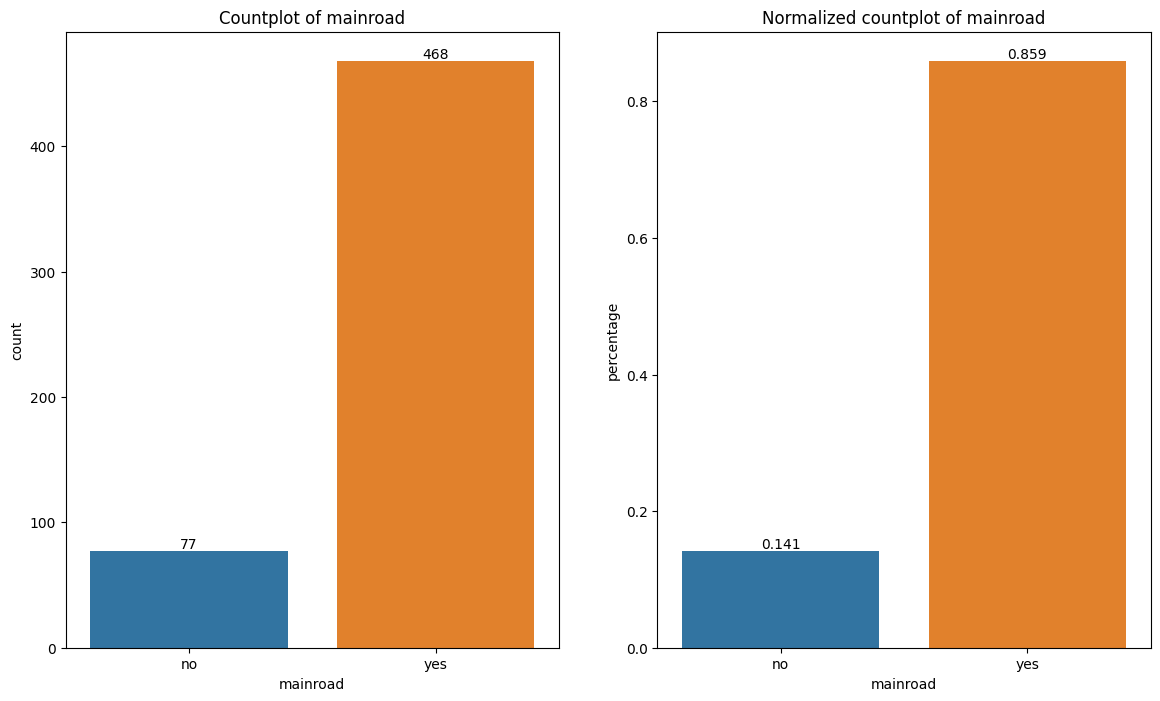

In [873]:
#displays a countplot and a normalized countplot for mainroad column 
plot_countplot(data = df, column='mainroad', size = (14,8))

- Almost 86% of the homes in this dataset are close to a main road

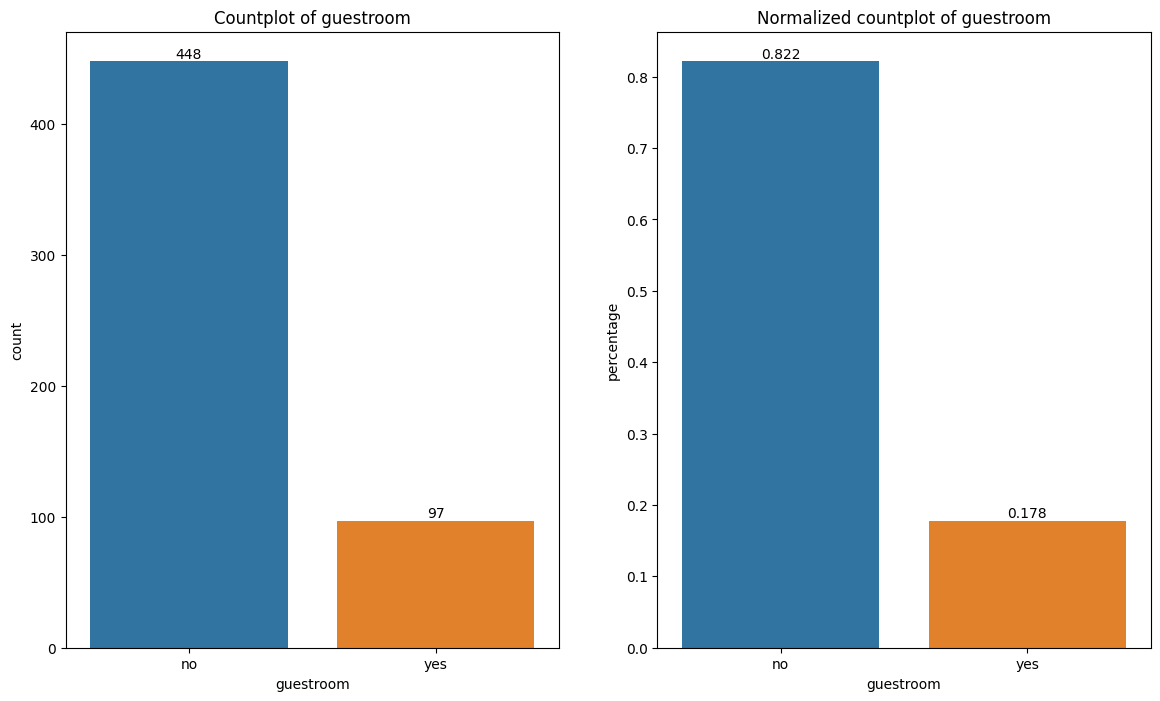

In [874]:
#displays a countplot and a normalized countplot for guestroom column 
plot_countplot(data = df, column='guestroom', size = (14,8))

- 82% of the homes in this dataset contain a guest room 

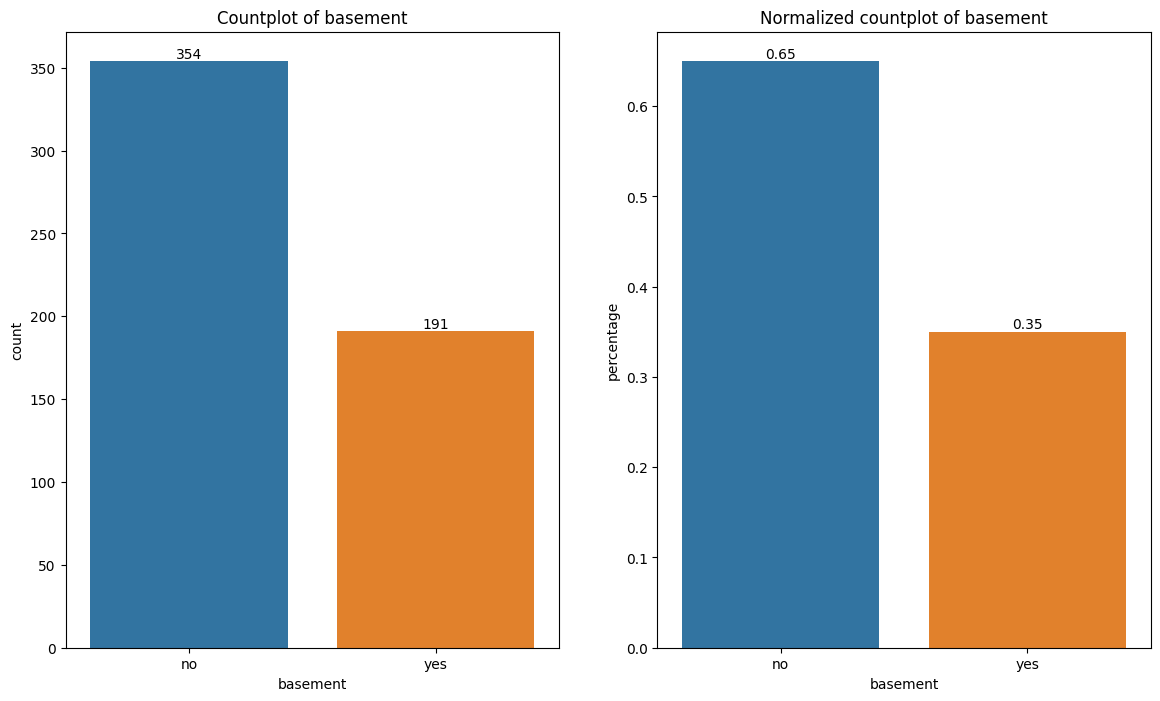

In [875]:
#displays a countplot and a normalized countplot for basement  column 
plot_countplot(data = df, column='basement', size = (14,8))

- 65% of the homes in this dataset contain a basement

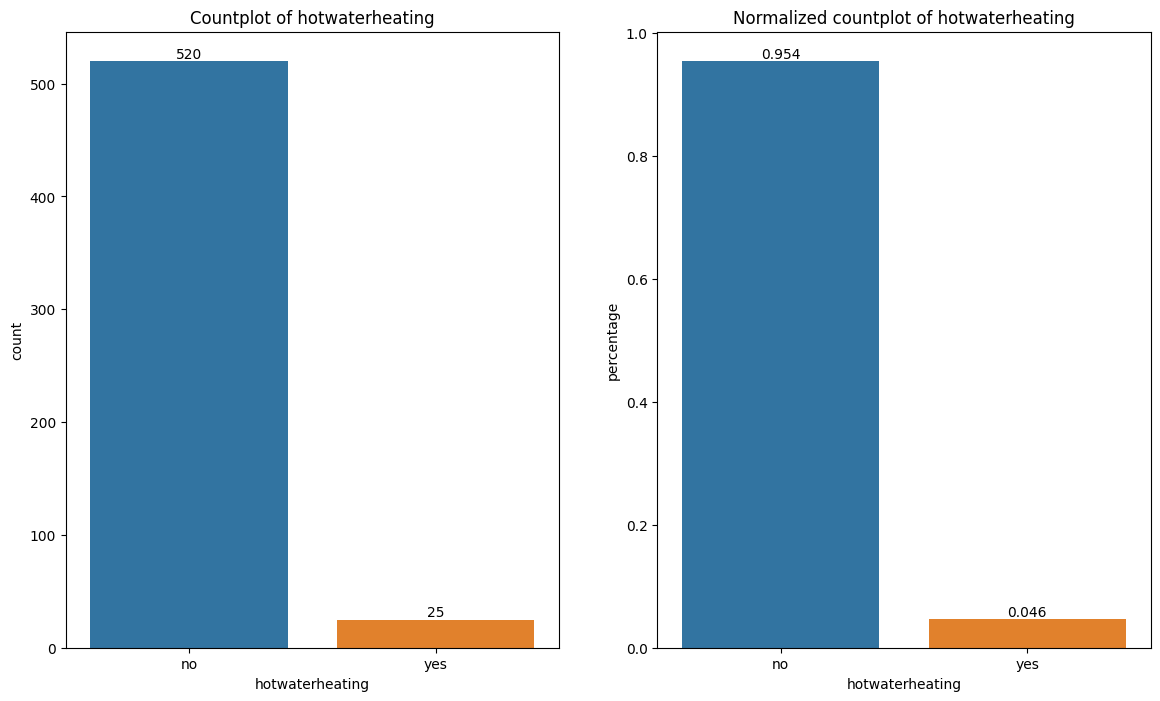

In [876]:
#displays a countplot and a normalized countplot for hotwater heating column 
plot_countplot(data = df, column='hotwaterheating', size = (14,8))

- 95% of the homes in this dataset have hot water heating

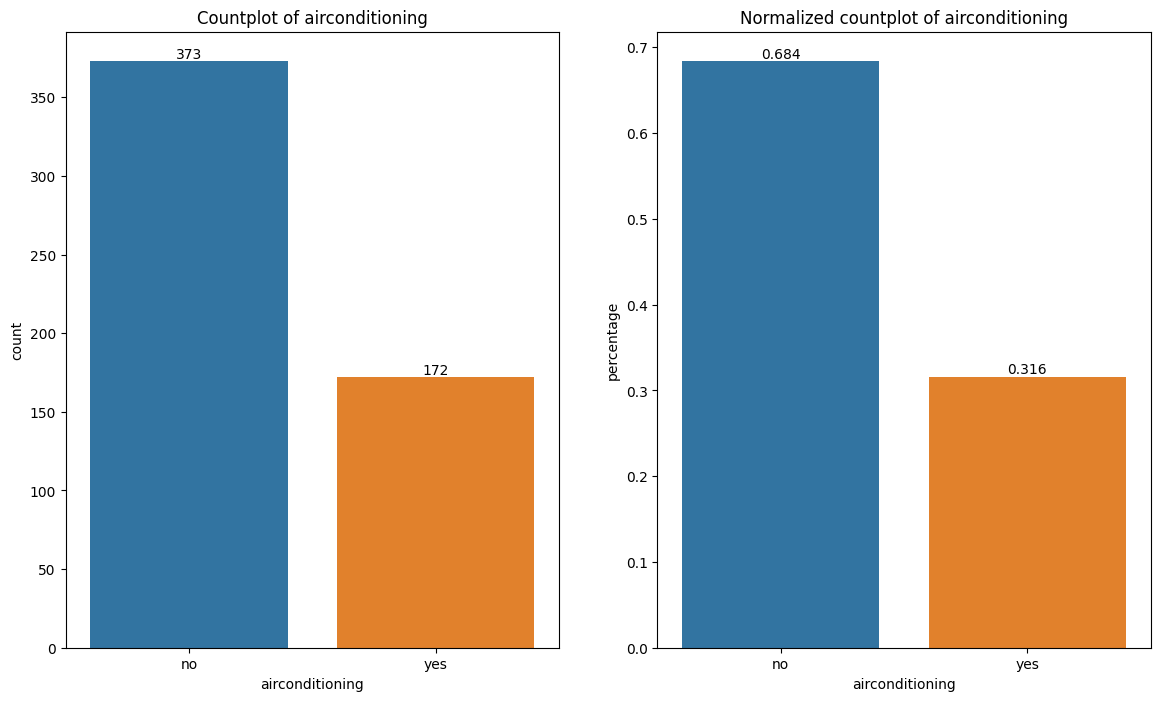

In [877]:
#displays a countplot and a normalized countplot for airconditioning column 
plot_countplot(data = df, column='airconditioning', size = (14,8))

- 68% of the houses do not have air conditioning
- so a large percentage of houses have hot water heater but no air conditioning ***statistically proves this**** 

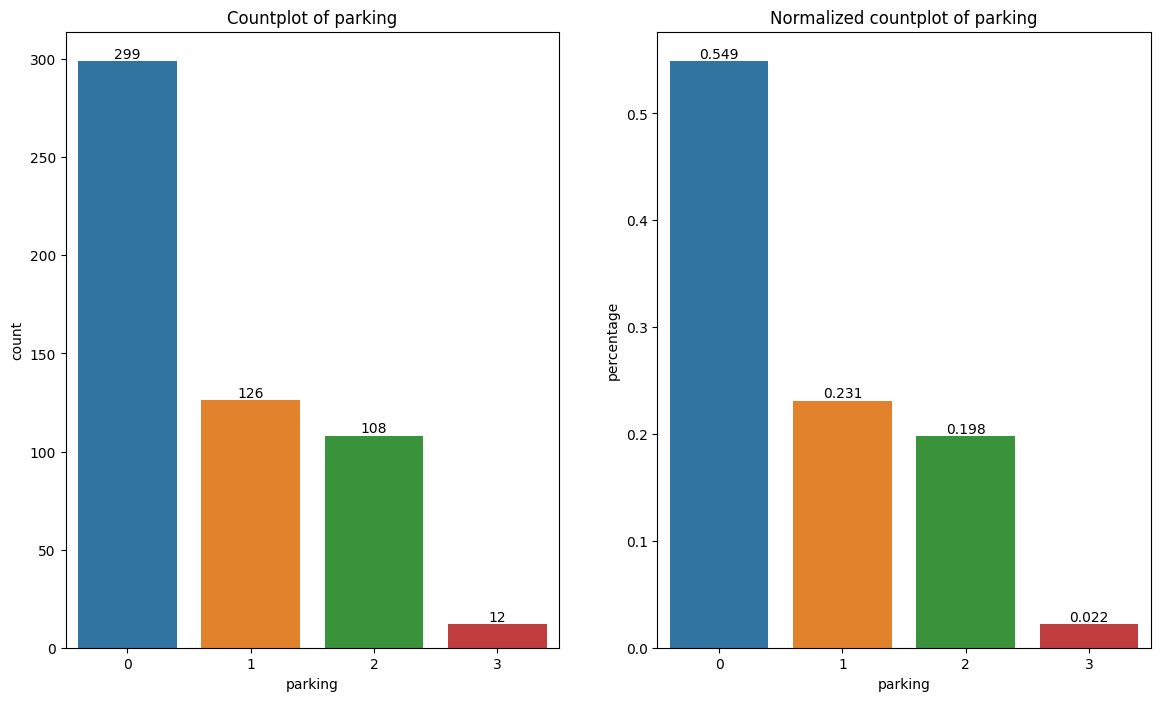

In [878]:
#displays a countplot and a normalized countplot for parking column 
plot_countplot(data = df, column='parking', size = (14,8))

- Over 50% of the houses do not contain any house parking spots
- Looks like as the amount of house parkings increase, the less prevalent they are in houses

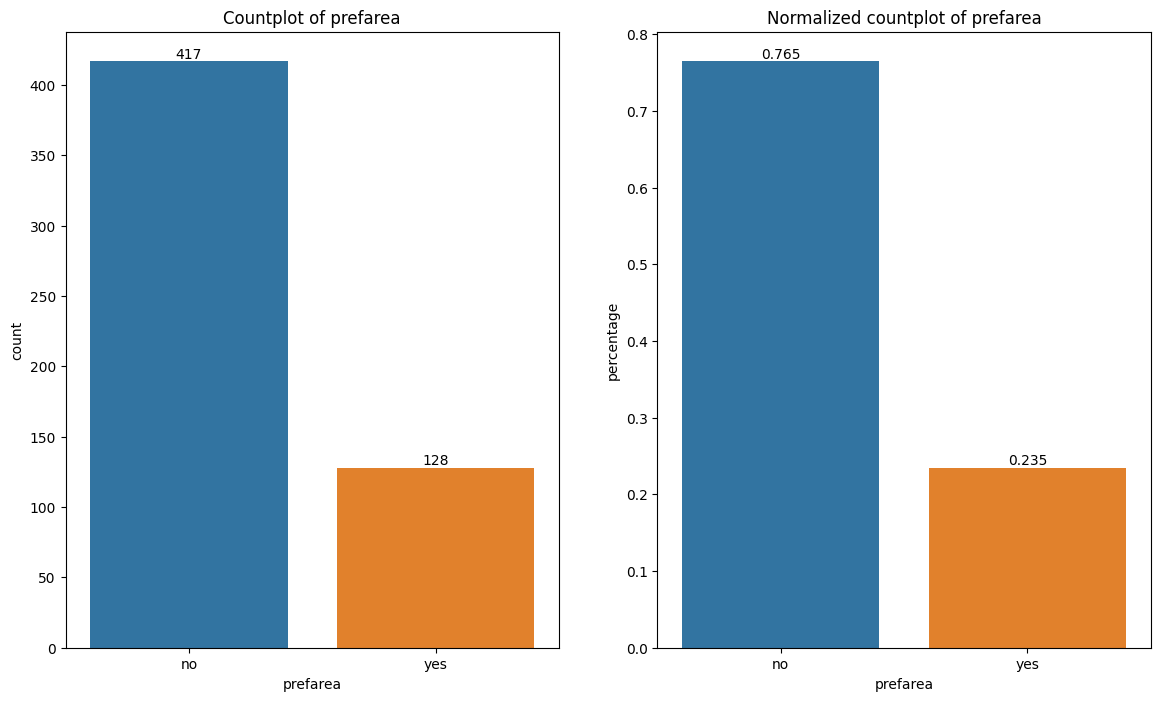

In [879]:
#displays a countplot and a normalized countplot for prefarea column 
plot_countplot(data = df, column='prefarea', size = (14,8))

- Majority of the houses do not prefer the area(?)

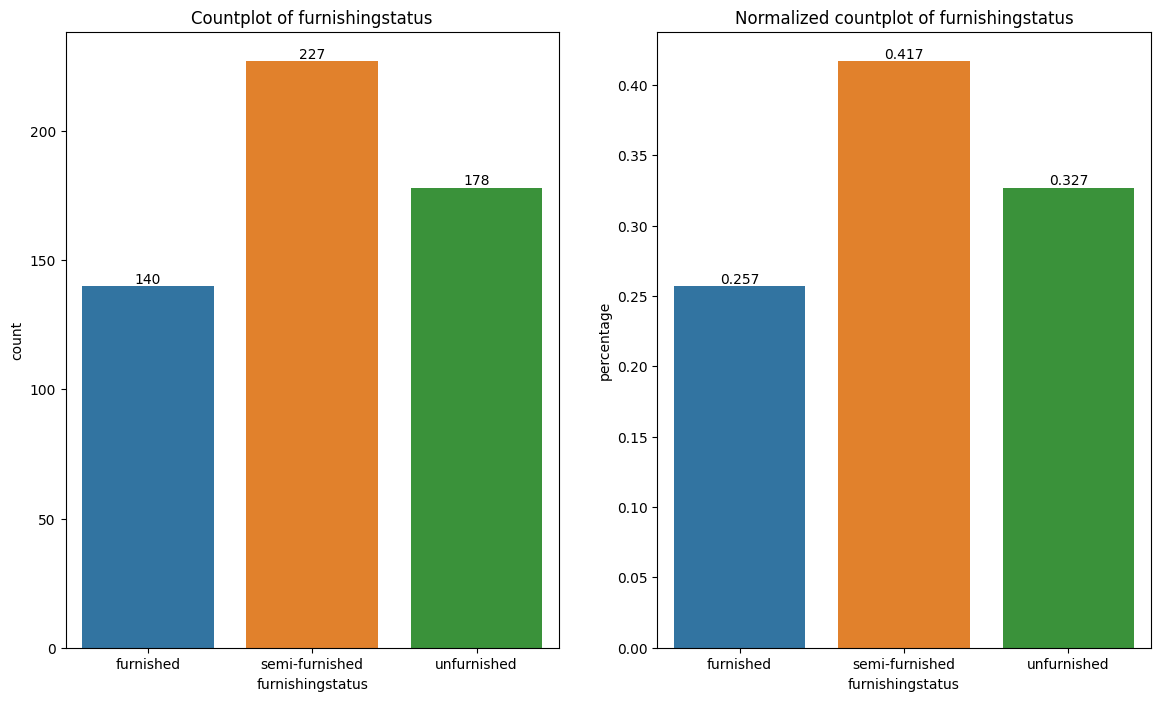

In [880]:
#displays a countplot and a normalized countplot for furnishingstatus column 
plot_countplot(data = df, column='furnishingstatus', size = (14,8))

- the most common furnishing status is semi-furnished
- Over 70% of the homes are either semi-furnished or unfurnished

## Multivariate Analysis

In [881]:
#This function creates a plot for the average price per class for column of interest and creates a boxplot per class for column of interest 
def average_price_per_column_plot(data, categorical_column, size):
    # creates a dataframe that displays average price per class for column of interest the price is normalized to 2 digits for easier interpretability 
    grouped_data = round((data.groupby(categorical_column)['price'].mean()/1000000),3).reset_index(name = 'Price (in millions)')
    plt.figure(figsize=size)
    plt.subplot(1,2,1)
    #displays bar graph with labels of average price per category for column of interest 
    ax = sns.barplot(data = grouped_data, x = 'Price (in millions)', y = categorical_column)
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f' bar plot Average price (in millions) per {categorical_column}')
   #displays boxplot of price per class for column of interest 
    plt.subplot(1,2,2)
    sns.boxplot(data = data, x = 'price', y = categorical_column)
    plt.title(f'Boxplot of price (in millions) per {categorical_column}')
    plt.show()

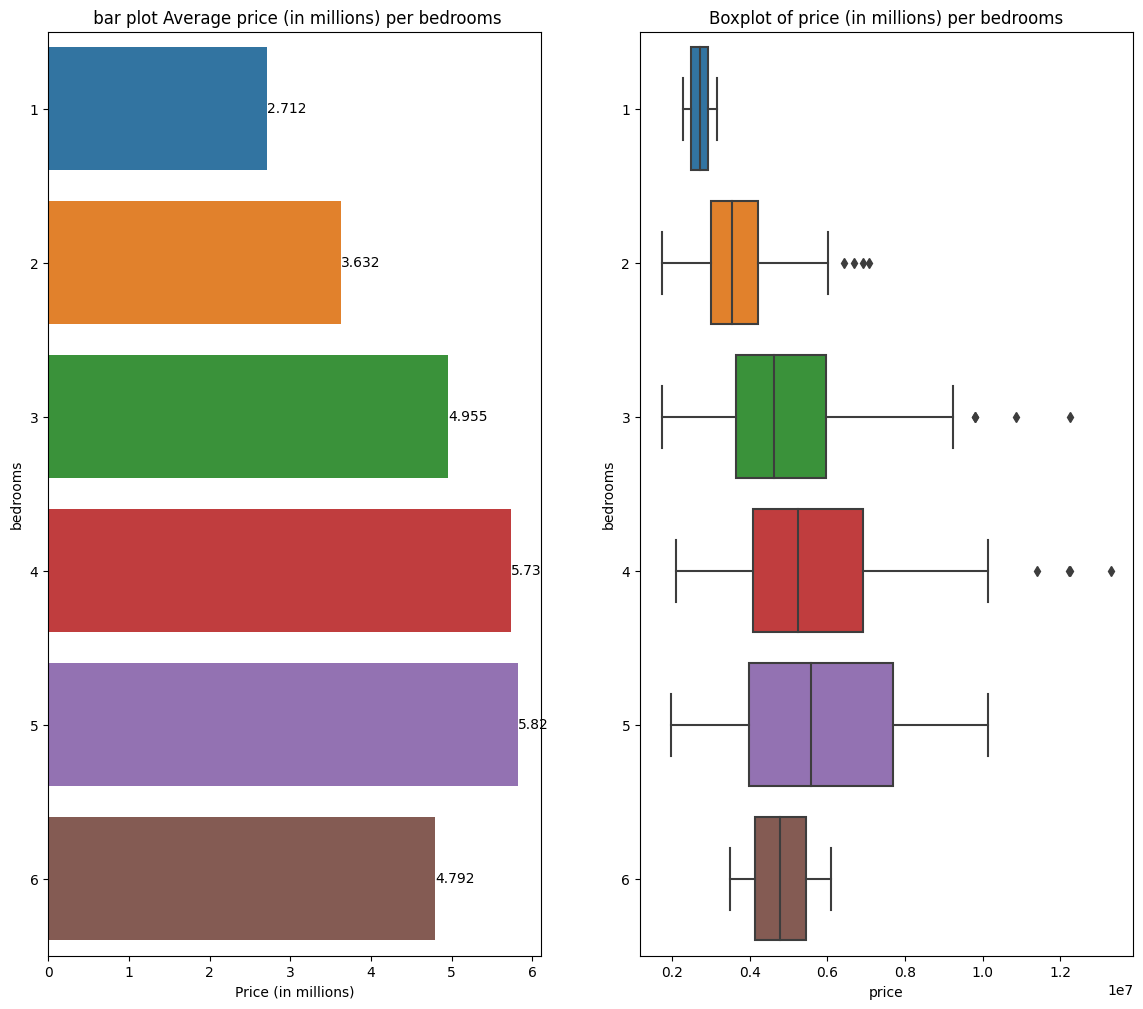

In [882]:
#displays barplot and boxplot per class for based on price for bedroom 
average_price_per_column_plot(data = df, categorical_column='bedrooms', size = (14,12))

- 1 bedroom houses are the least expensive houses
- 4 and 5 bedroom houses are the most expensive 
- 6 bedrooms are not the most expensive but they maybe due to a low number of examples 
- 3 and 4 bedroom contain home prices that are over $10 million
- range of values for 6 bedroom are significantly cheaper than the 3,4,5
- In this case 3,4,5 bedrooms are typically more valuable than the rest based on distribution

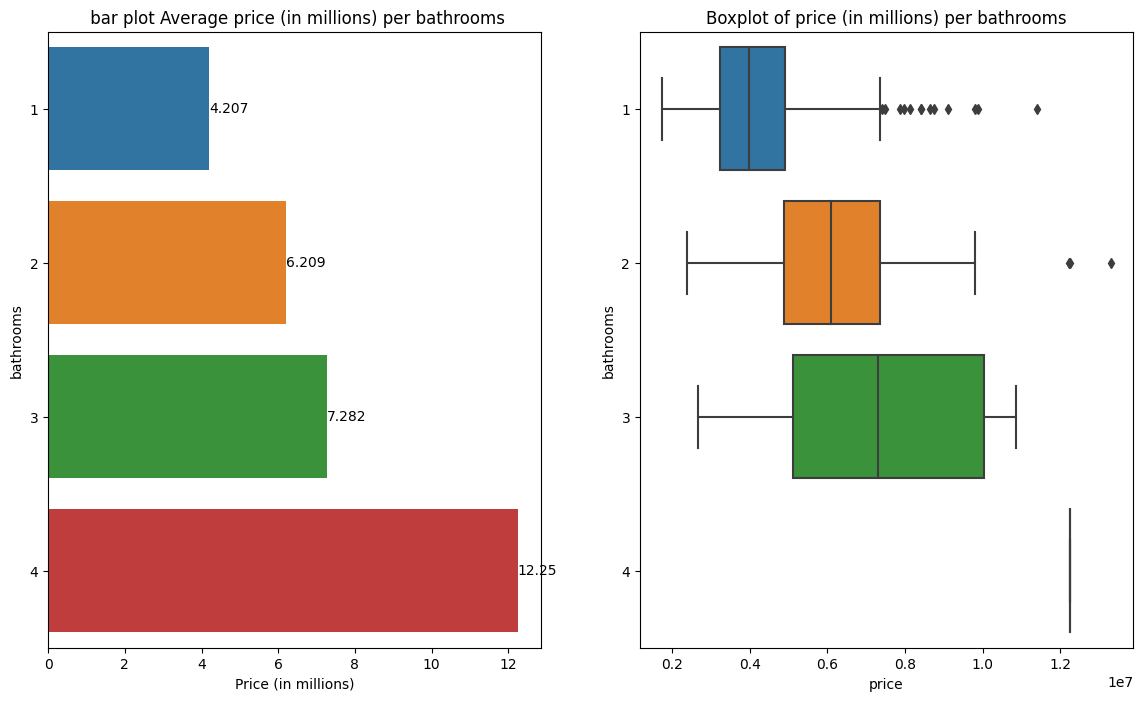

In [883]:
#displays barplot and boxplot per class for based on price for bathrooms
average_price_per_column_plot(data = df, categorical_column='bathrooms', size = (14,8))

- The more amount of bathrooms, the more expensive the house is
- There are some 2 bathroom homes that are more expensive 3 or 4 bathroom homes
- there is a one bathroom that is more expensive than some 2 and 3 bathroom homes

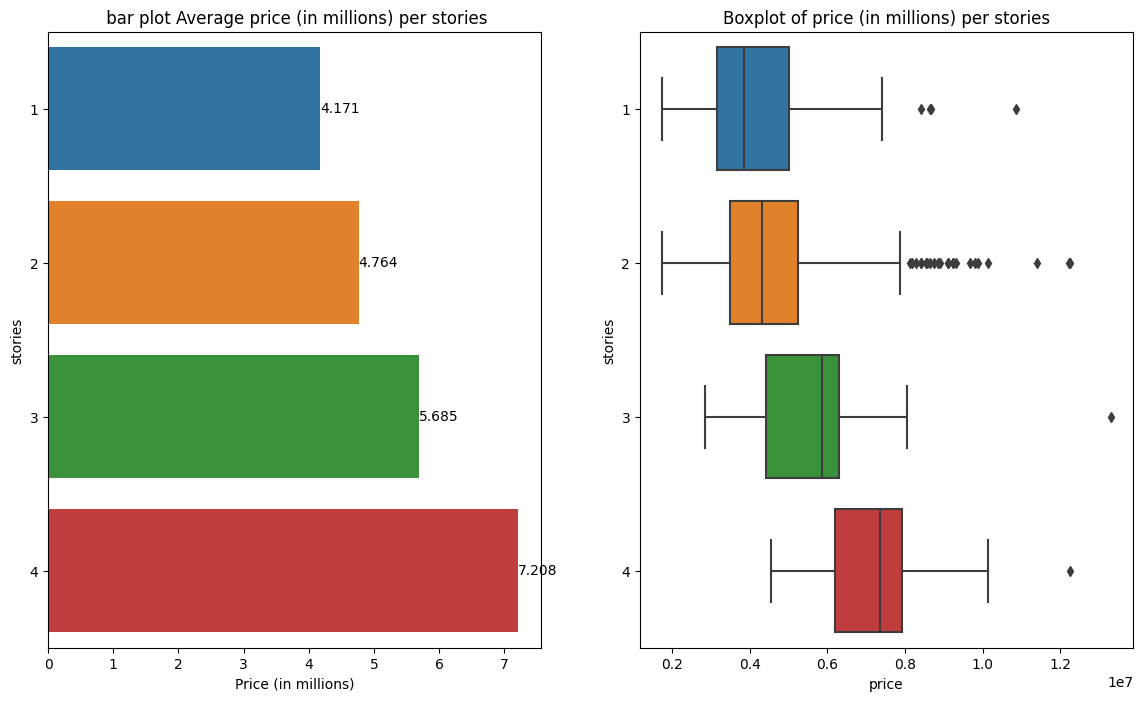

In [884]:
#displays barplot and boxplot per class for based on price for stories
average_price_per_column_plot(data = df, categorical_column='stories', size = (14,8))

- as the number of stories increase the more expensive it is
- the most expensive house is a 3 story house
- 4 story has the highest average price value
- there is a one story house that is more expensive than some 2 and 3 story houses

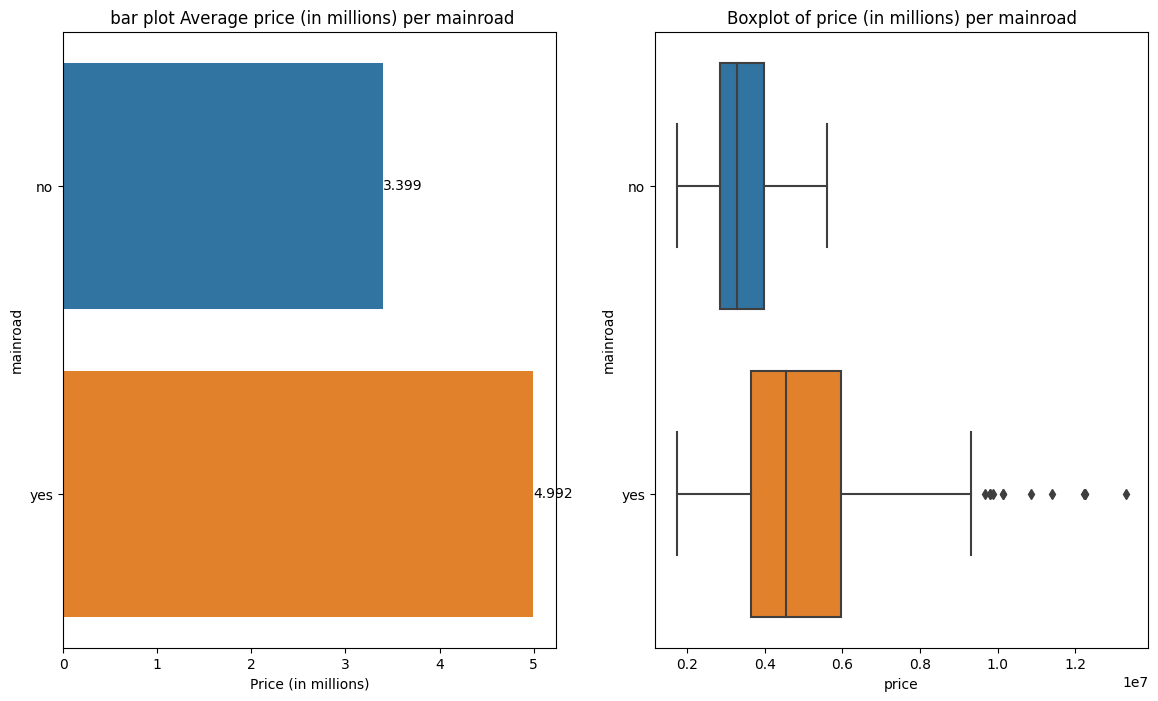

In [885]:
#displays barplot and boxplot per class for based on price for mainroad 
average_price_per_column_plot(data = df, categorical_column='mainroad', size = (14,8))

- Houses that are close to a main road are more expensive on average

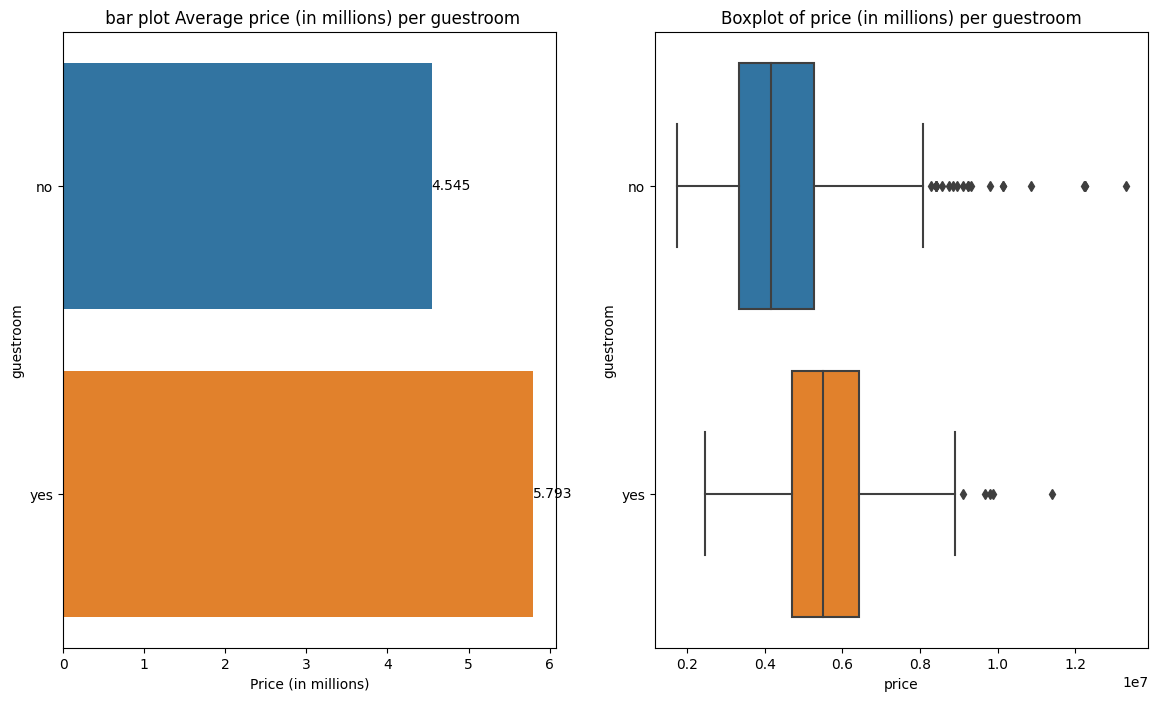

In [886]:
#displays barplot and boxplot per class for based on price for guestroom 
average_price_per_column_plot(data = df, categorical_column='guestroom', size = (14,8))

- On average, homes that contain a guestroom are more expensive
- 2 of the most expensive houses do not contain a guest room 


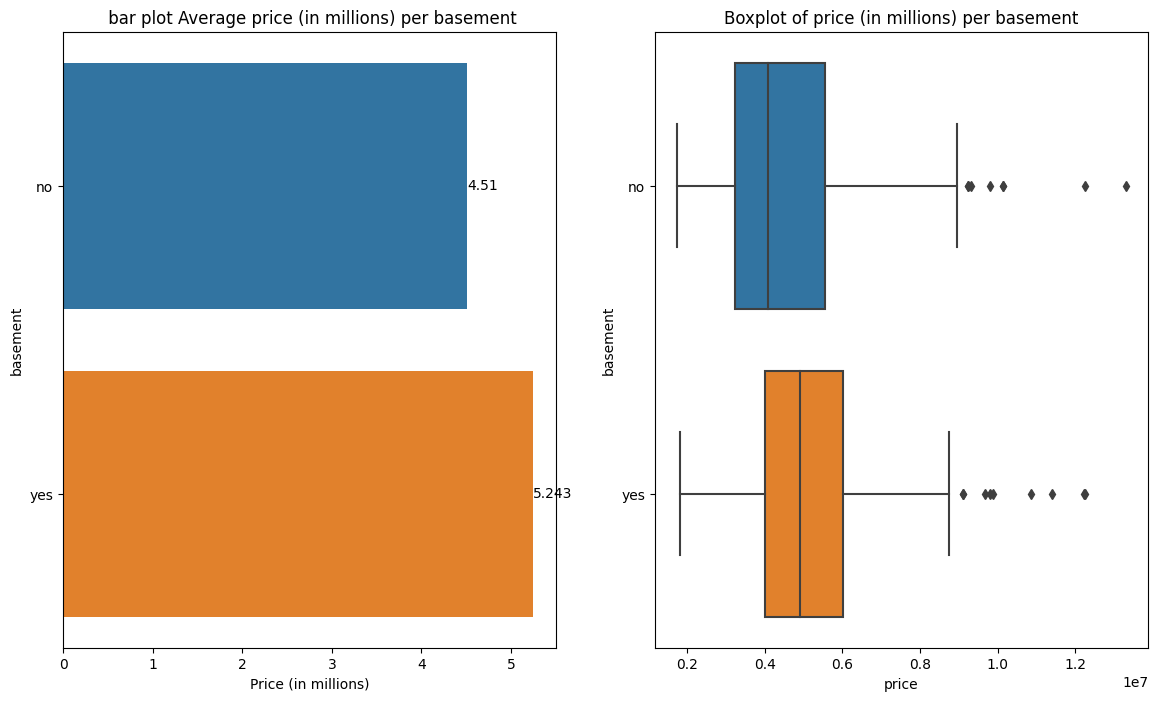

In [887]:
#displays barplot and boxplot per class for based on price for basement
average_price_per_column_plot(data = df, categorical_column='basement', size = (14,8))

- On average, houses that contain a basement are more expensive
- 2 out of the 3 most expensive houses do not contain a basement

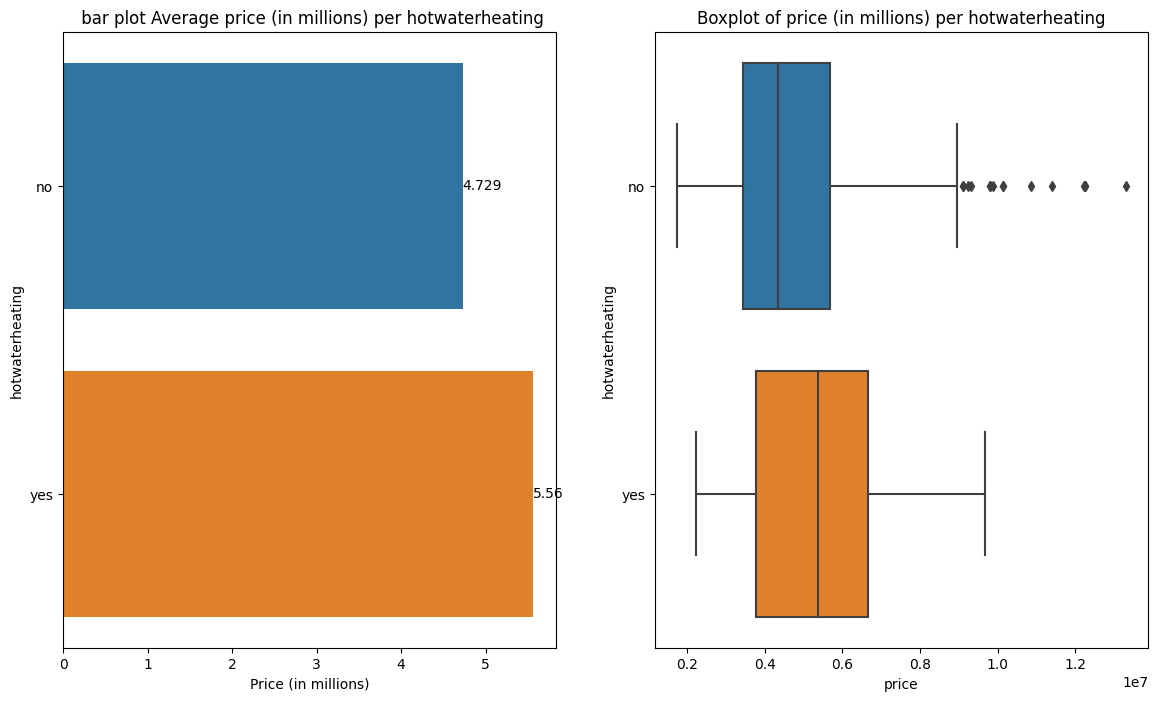

In [888]:
#displays barplot and boxplot per class for based on price for hotwaterheating
average_price_per_column_plot(data = df, categorical_column='hotwaterheating', size = (14,8))

- On average, houses that contain a hot water heater are more expensive
- The most expensive houses DO NOT contain a hot water heater

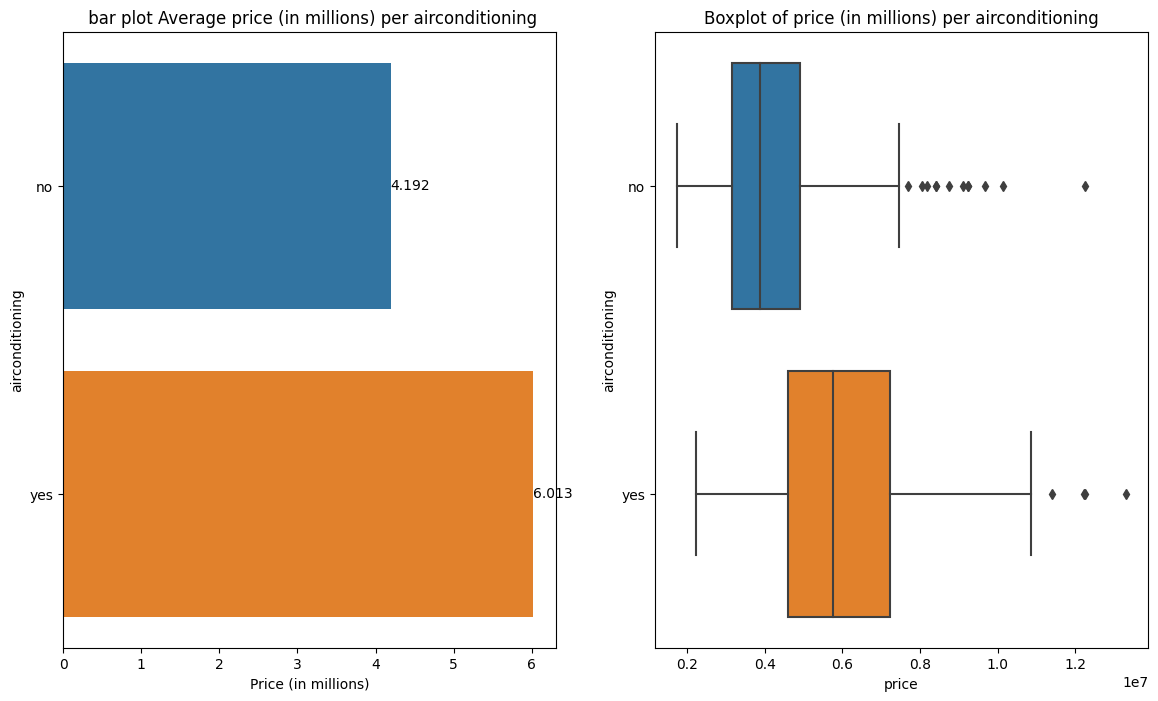

In [889]:
#displays barplot and boxplot per class for based on price for airconditioning
average_price_per_column_plot(data = df, categorical_column='airconditioning', size = (14,8))

- On average, houses that has airconditioning are more expensive
- There is a house that is over $10 million dollars that does not contain airconditioning

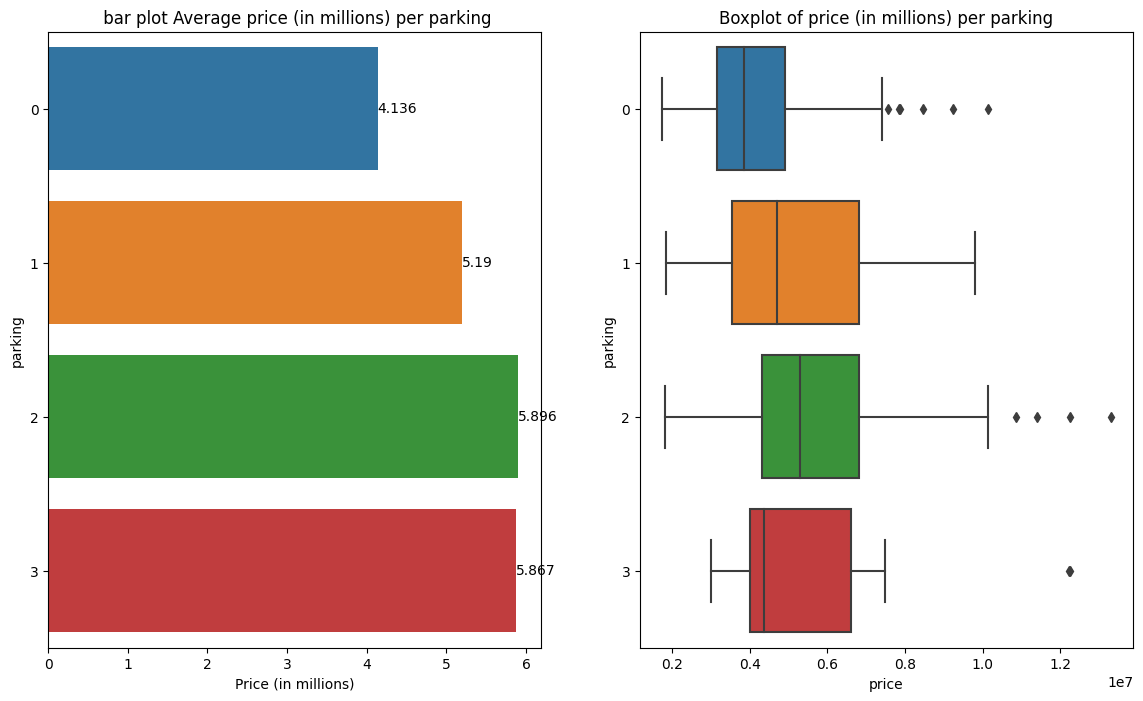

In [890]:
#displays barplot and boxplot per class for based on price for parking
average_price_per_column_plot(data = df, categorical_column='parking', size = (14,8))

- on average, the more parking spots, the more expensive
- houses that have 1 or 2 parking spots have the most dispersion in terms of price
- 2 parking spot houses has a larger upper bound iqr range than 3 parking spot houses

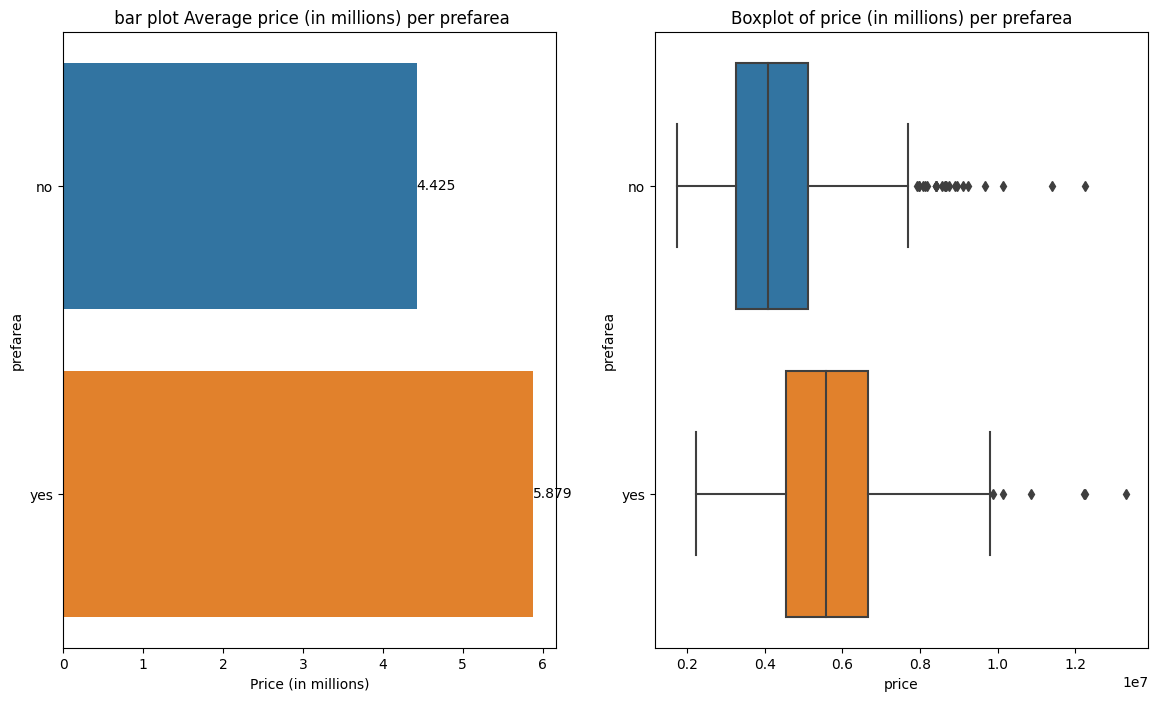

In [891]:
#displays barplot and boxplot per class for based on price for prefarea
average_price_per_column_plot(data = df, categorical_column='prefarea', size = (14,8))

- On average, houses that are more expensive prefer the area
- There are some expensive houses where the area is not preferred but those are considered outliers 

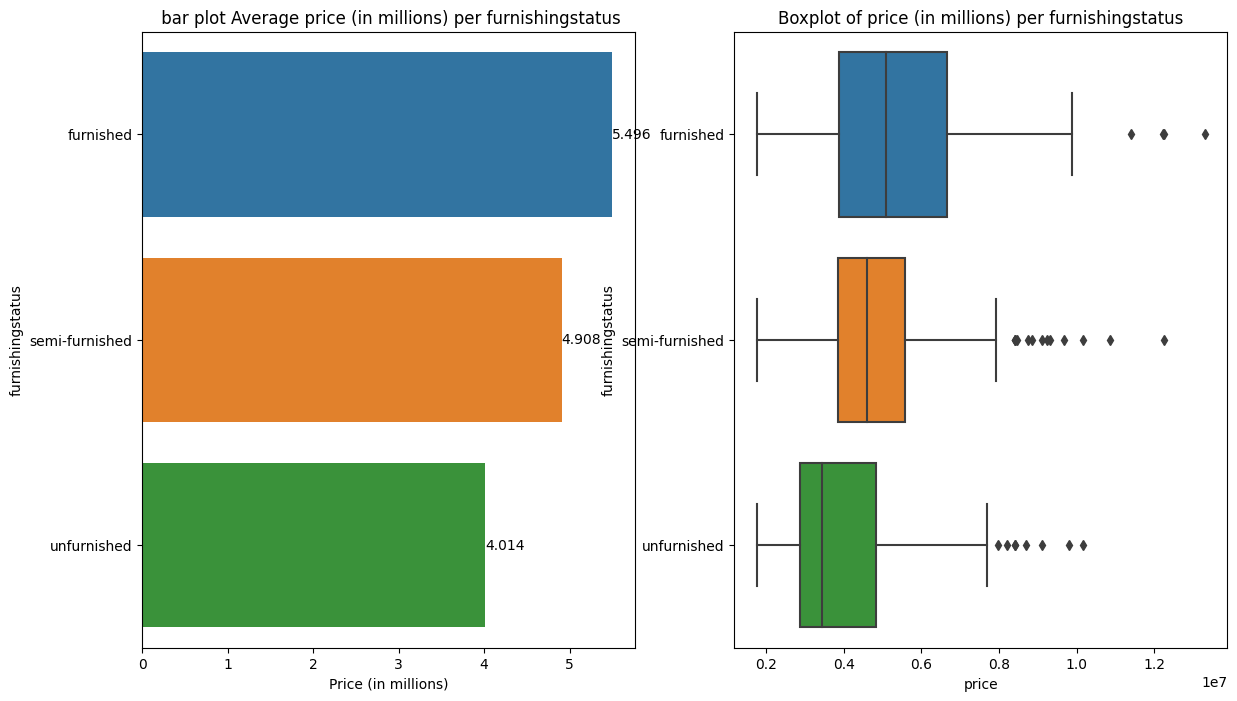

In [892]:
#displays barplot and boxplot per class for based on price for furnishingstatus
average_price_per_column_plot(data = df, categorical_column='furnishingstatus', size = (14,8))

- On average, furnished prices are more expensive 
- furnished prices have the largest dispersion in terms of pricing 


<Axes: >

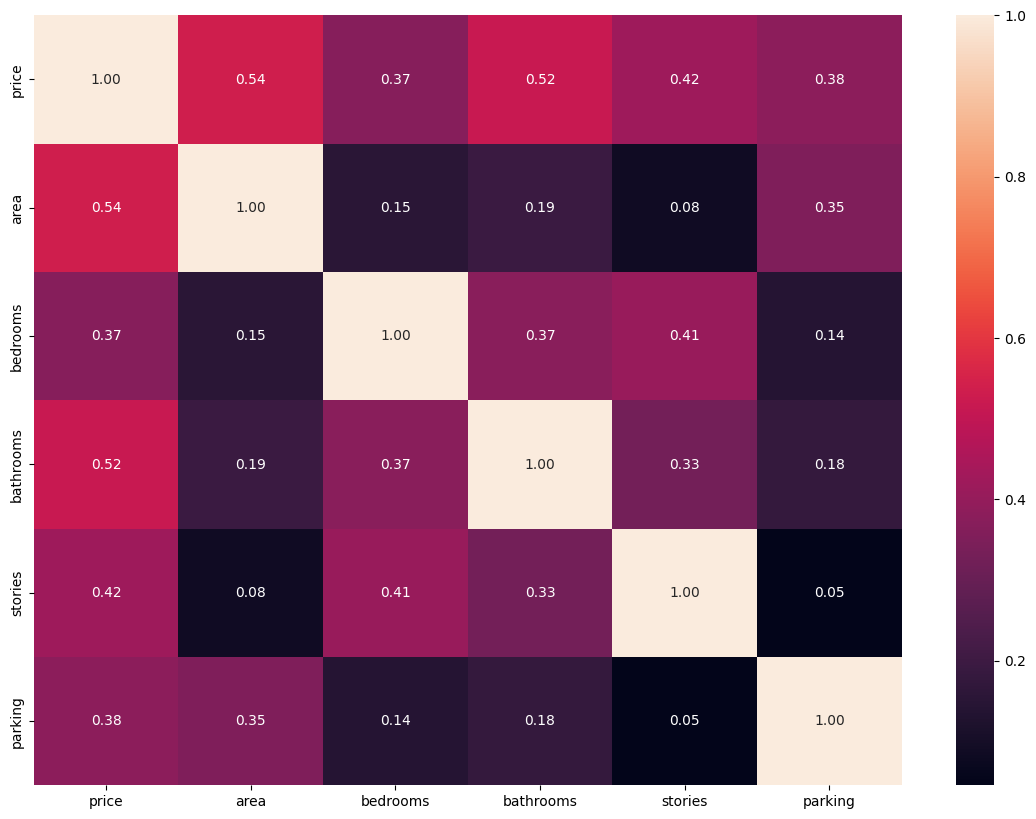

In [893]:
#convert the columns with discrete numerical variables from category to integers
counting_columns = ['bedrooms', 'bathrooms', 'stories', 'parking']
df[counting_columns] = df[counting_columns].astype('int64')
#plot a correlation heatmap that consists of only columns that are integers and floats in the dataframe
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include = ['float64', 'int64']).corr(), annot = True, fmt = '.2f')

- columns have a moderate, positive relationship with price 

In [894]:
#create a divsion function that performs division but if y is zero then zero will be turned 
def safe_division(x,y):
    if y != 0:
        return x/y
    else:
        return 0

In [895]:
#create a list that contains integer and float columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
#remove price from the column to prevent data leakge
numerical_columns.remove('price')
#remove area because it will be dividing by itself
numerical_columns.remove('area')
#create mulitple columns where area is divided by the column                          
for column in numerical_columns:
    df[f'area/{column}'] = df.apply(lambda x: safe_division(x['area'], x[column]), axis = 1)


In [896]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
#transform the class values for each category column into a number
label_encoder = LabelEncoder()
string_columns = df.select_dtypes(include = 'category').columns.to_list()
for string in string_columns:
    df[string] = label_encoder.fit_transform(df[string])


In [897]:
print('Variance per column', '\n', df.var().sort_values(ascending = True))

Variance per column 
 hotwaterheating     4.384781e-02
mainroad            1.215461e-01
guestroom           1.465731e-01
prefarea            1.800324e-01
airconditioning     2.163923e-01
basement            2.280559e-01
bathrooms           2.524757e-01
bedrooms            5.447383e-01
furnishingstatus    5.796883e-01
parking             7.423300e-01
stories             7.525432e-01
area/bedrooms       7.040751e+05
area/bathrooms      4.504376e+06
area                4.709512e+06
area/stories        5.045106e+06
area/parking        6.823604e+06
price               3.498544e+12
dtype: float64


Hot water heating is the only column that has a variance of less than 0.1. Columns with that low of variance do not provide the machine learning model enough information for learning. 

In [898]:
#create a variable that displays variance per column as a series
variance_per_column = df.var()
#extract only the columns that have a higher variance than 0.1 and convert them into a list 
columns_with_var_greater_than_0_1 = variance_per_column.loc[variance_per_column.values > 0.1].index.to_list()
#extract only the columns that have a lower variance than 0.1 and convert them into a list 
columns_with_var_less_than_0_1  = variance_per_column.loc[variance_per_column.values < 0.1].index.to_list()
print('Columns where the variance is greater than 0.1:', '\n', columns_with_var_greater_than_0_1)
[print('Columns where the variance is less than 0.1:', '\n', columns_with_var_less_than_0_1)]

Columns where the variance is greater than 0.1: 
 ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus', 'area/bedrooms', 'area/bathrooms', 'area/stories', 'area/parking']
Columns where the variance is less than 0.1: 
 ['hotwaterheating']


[None]

In [899]:
print('Before setting variance threshold for feature selection:', df.shape)
#keep only the columns that have a variance higher than 0.1
df = df[columns_with_var_greater_than_0_1]
print('After setting variance threshold for feature selection:', df.shape)

Before setting variance threshold for feature selection: (545, 17)
After setting variance threshold for feature selection: (545, 16)


In [900]:
#columns that will be one hot encoded are the category columns aka string columns
one_hot_columns = string_columns
#remove hotwaterheating because it has a variance of less than 0.1
one_hot_columns.remove('hotwaterheating')
#create a series that displays the number of unique values per  category column 
number_of_unique_one_hot_columns = df[one_hot_columns].nunique()
#using the series extract the category columns that have more than 2 unique values
one_hot_columns = number_of_unique_one_hot_columns.loc[number_of_unique_one_hot_columns.values > 2].index.to_list()



In [901]:
#a function that returns dataframe that combines the original dataframe with a dataframe of one hot encoded columns of columns of interest
def perform_one_hot_encoding(data, drop_first, one_hot_columns):
    #Use the drop first mehtod
    if drop_first: 
        one_hot = OneHotEncoder(drop='first', sparse=False)
    #Not using drop first method 
    else:
        one_hot = OneHotEncoder(sparse=False)
    #create a dataframe of one hot encoded columns 
    one_hot_df = pd.DataFrame(one_hot.fit_transform(data[one_hot_columns]), columns = one_hot.get_feature_names_out(one_hot_columns))
    #combine original dataframe and one hot encoded dataframe 
    data = pd.concat((data, one_hot_df), axis = 1)
    #remove the original columns of interest because onehot encoded columns oc olumns of interest are replacing them 
    data.drop(one_hot_columns, axis = 1, inplace = True)
    return data


In [902]:
#create a copy of the original dataframe specifically for stats model linear regression which uses the drop first rule for one hot encoding 
stats_model_df = df.copy()

In [903]:
#use onehot encoding function using the drop first option 
stats_model_df = perform_one_hot_encoding(data = stats_model_df, drop_first=True, one_hot_columns=one_hot_columns)
stats_model_df

c:\Users\dgmur\python\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,area/bedrooms,area/bathrooms,area/stories,area/parking,furnishingstatus_1,furnishingstatus_2
0,13300000,7420,4,2,3,1,0,0,1,2,1,1855.000000,3710.0,2473.333333,3710.000000,0.0,0.0
1,12250000,8960,4,4,4,1,0,0,1,3,0,2240.000000,2240.0,2240.000000,2986.666667,0.0,0.0
2,12250000,9960,3,2,2,1,0,1,0,2,1,3320.000000,4980.0,4980.000000,4980.000000,1.0,0.0
3,12215000,7500,4,2,2,1,0,1,1,3,1,1875.000000,3750.0,3750.000000,2500.000000,0.0,0.0
4,11410000,7420,4,1,2,1,1,1,1,2,0,1855.000000,7420.0,3710.000000,3710.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,2,0,1500.000000,3000.0,3000.000000,1500.000000,0.0,1.0
541,1767150,2400,3,1,1,0,0,0,0,0,0,800.000000,2400.0,2400.000000,0.000000,1.0,0.0
542,1750000,3620,2,1,1,1,0,0,0,0,0,1810.000000,3620.0,3620.000000,0.000000,0.0,1.0
543,1750000,2910,3,1,1,0,0,0,0,0,0,970.000000,2910.0,2910.000000,0.000000,0.0,0.0


Drop first was used for linear regression to counter dummy variable trap which can cause columns to be perfectly collinear with each other 

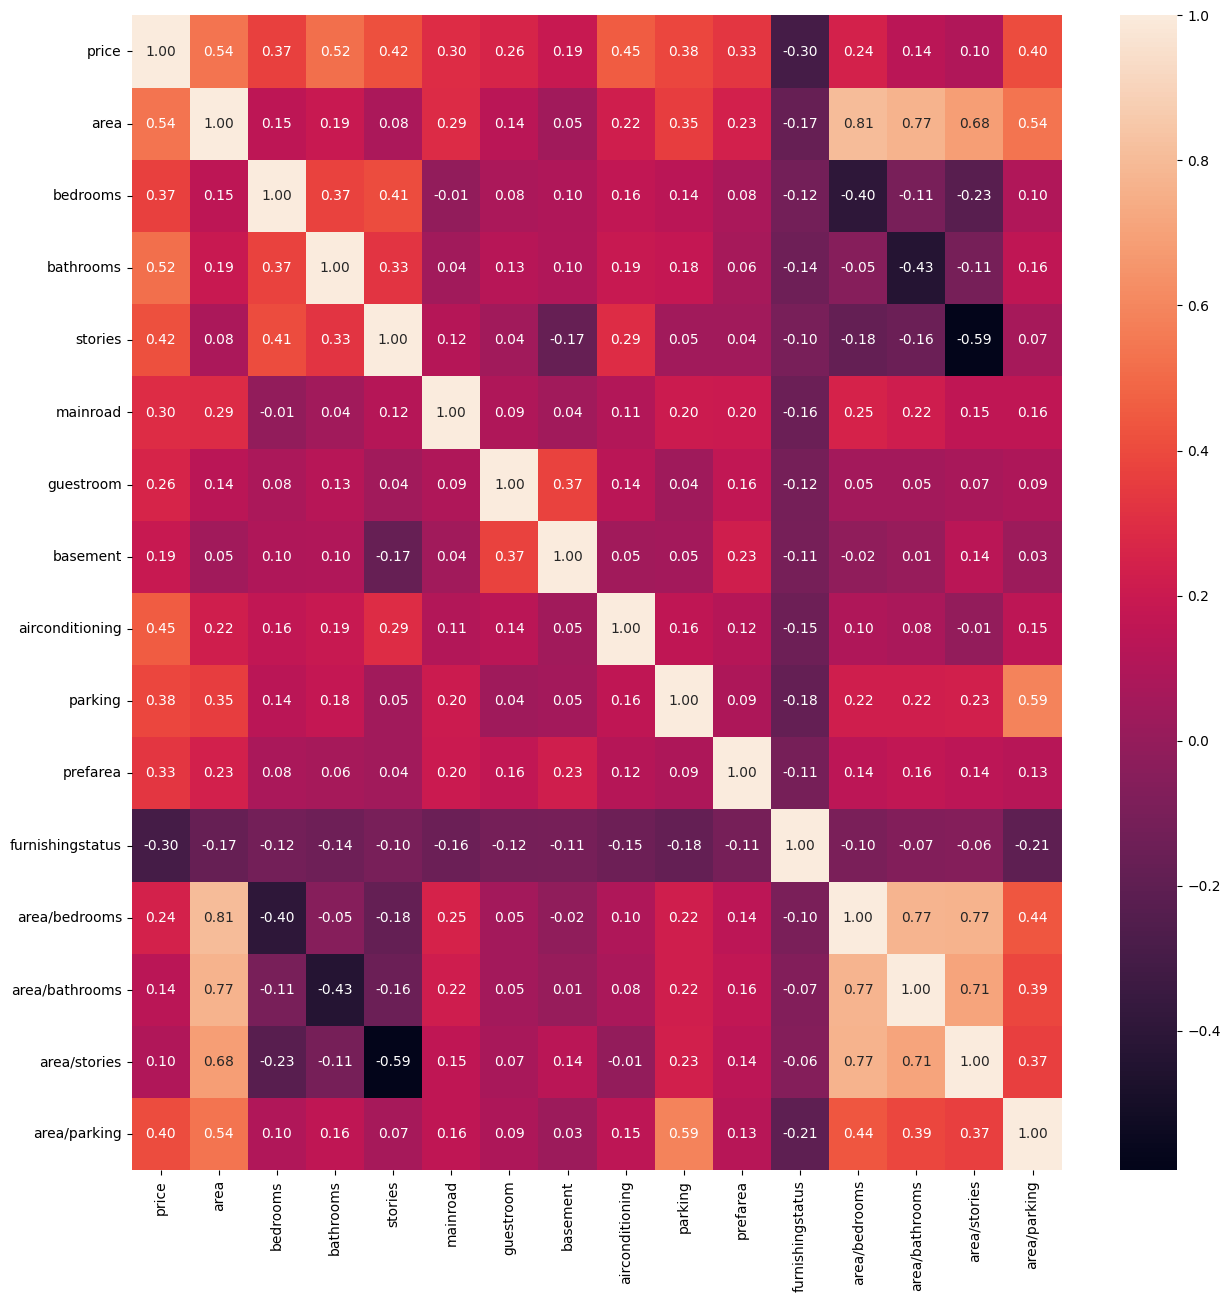

In [904]:
#plots a correlation heatmap 
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot = True, fmt = '.2f')
plt.show()

- There are some signs of multicollinearity for area columns 

In [905]:
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#performs variance inflation factor and returns a dataframe that displays the columns along with its variance inflation factor value
def find_vif(data):
    #fits a linear regression model using price as the respone variable and the rest of the variables as predictors
    formula = 'price ~'+'+'.join(data.drop('price', axis = 1).columns)    
    vif_regression_model = sm.ols(formula, data = data).fit()
    #extracts predictor variable names
    variable_names = vif_regression_model.model.exog_names
    #extracts the index of the predictor variables 
    variables = vif_regression_model.model.exog
    #create a dataframe that displays columns and vif values
    vif_data = pd.DataFrame()
    vif_data['Feature'] = variable_names
    vif_data['VIF'] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
    #excludes intercept because intercept is not affected by vif
    return vif_data.loc[vif_data['Feature'] != 'Intercept']



In [906]:
stats_model_df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,area/bedrooms,area/bathrooms,area/stories,area/parking,furnishingstatus_1,furnishingstatus_2
0,13300000,7420,4,2,3,1,0,0,1,2,1,1855.000000,3710.0,2473.333333,3710.000000,0.0,0.0
1,12250000,8960,4,4,4,1,0,0,1,3,0,2240.000000,2240.0,2240.000000,2986.666667,0.0,0.0
2,12250000,9960,3,2,2,1,0,1,0,2,1,3320.000000,4980.0,4980.000000,4980.000000,1.0,0.0
3,12215000,7500,4,2,2,1,0,1,1,3,1,1875.000000,3750.0,3750.000000,2500.000000,0.0,0.0
4,11410000,7420,4,1,2,1,1,1,1,2,0,1855.000000,7420.0,3710.000000,3710.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,2,0,1500.000000,3000.0,3000.000000,1500.000000,0.0,1.0
541,1767150,2400,3,1,1,0,0,0,0,0,0,800.000000,2400.0,2400.000000,0.000000,1.0,0.0
542,1750000,3620,2,1,1,1,0,0,0,0,0,1810.000000,3620.0,3620.000000,0.000000,0.0,1.0
543,1750000,2910,3,1,1,0,0,0,0,0,0,970.000000,2910.0,2910.000000,0.000000,0.0,0.0


In [907]:
#preforms vif function for the dataframe that's specialized for statsmodels 
vif_data = find_vif(stats_model_df)
vif_data

,Feature,VIF
1,area,18.762810
2,bedrooms,9.825102
3,bathrooms,9.055400
4,stories,14.693802
5,mainroad,1.211978
6,guestroom,1.237744
7,basement,1.340763
8,airconditioning,1.196480
9,parking,8.440291
10,prefarea,1.154008


VIF measures how much variance regression coefficient is inflated due to mutlicollinearity
- Area, stories, area/bedroom. area/bathrooms, area/stories and area/parking have a VIF value of over 10, indicating that those columns are mulitcollinear
- PCA will be used to merge highly correlated columns together while maximizing variance in order to eliminate mulitcollinearity

In [908]:
#filter columns that have a VIF values of over 10 and convert them into a list 
variables_with_high_vif = vif_data.loc[vif_data['VIF'] > 10]['Feature'].to_list()
print('Columns with a high VIF:', '\n', variables_with_high_vif)

Columns with a high VIF: 
 ['area', 'stories', 'area:bedrooms', 'area:bathrooms', 'area:stories', 'area:parking']


In [909]:
#perform one hot encoding function that does not use drop first rule
df = perform_one_hot_encoding(data=df, drop_first=False, one_hot_columns=one_hot_columns)

c:\Users\dgmur\python\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [910]:
from sklearn.decomposition import PCA
#adds a pc columns based on pca algorithm using a columns contain a specific word in them 
def create_pca_column(data, column_of_interest):
    #perfrom pca using 2 components 
    pca = PCA(n_components=2)
    #extract columns that contain a word or characters of interest
    columns = data.filter(like = column_of_interest).columns.to_list()
    #scale the column values to make sure the values of each column are the same magnitude as each other 
    scaler_for_pca = StandardScaler()
    #performed pca on the scaled columns 
    scaled_data = scaler_for_pca.fit_transform(data[columns])
    #performed pca on the scaled columns 
    pca.fit(scaled_data)
    print('explained_variance ratio:', sum(pca.explained_variance_ratio_))
    #create dataframe for the pca values 
    pca_df = pd.DataFrame(pca.transform(scaled_data), columns = [f'{column_of_interest}_PC{i+1}' for i in range(pca.n_components_)])
    #combine the pc columns to the original dataframe 
    data = pd.concat((data, pca_df), axis = 1 )
    #remove the columns that pc was performed on because they will be replaced by the pc columns 
    data.drop(columns, axis = 1, inplace = True)
    return data


In [911]:
#perform pca function for columns that contain the word area
df = create_pca_column(data = df, column_of_interest='area')

explained_variance ratio: 0.759871929404953


- merge area columns using pca, and extract two pcs that contain the 76% of the variance from the area columns as a whole

In [912]:
#display all the columns 
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'basement', 'airconditioning', 'parking', 'furnishingstatus_0',
       'furnishingstatus_1', 'furnishingstatus_2', 'area_PC1', 'area_PC2'],
      dtype='object')

In [913]:
print('Shape of datafame after performing pca:', df.shape)

Shape of datafame after performing pca: (545, 14)


In [914]:
#perform pca function for columns that contain the word area
ew_stats_model_df = create_pca_column(data=stats_model_df, column_of_interest='area')
#receck vif to see if all columns have a vif value of less than 10
new_vif_data = find_vif(new_stats_model_df)
new_vif_data

explained_variance ratio: 0.7598719294049526


,Feature,VIF
1,bedrooms,1.375739
2,bathrooms,1.279842
3,stories,1.567255
4,mainroad,1.170872
5,guestroom,1.210754
6,basement,1.320773
7,airconditioning,1.186020
8,parking,1.204445
9,furnishingstatus_1,1.577505
10,furnishingstatus_2,1.674051


- After using pca, there are no columns that have a VIF of 10 or higher

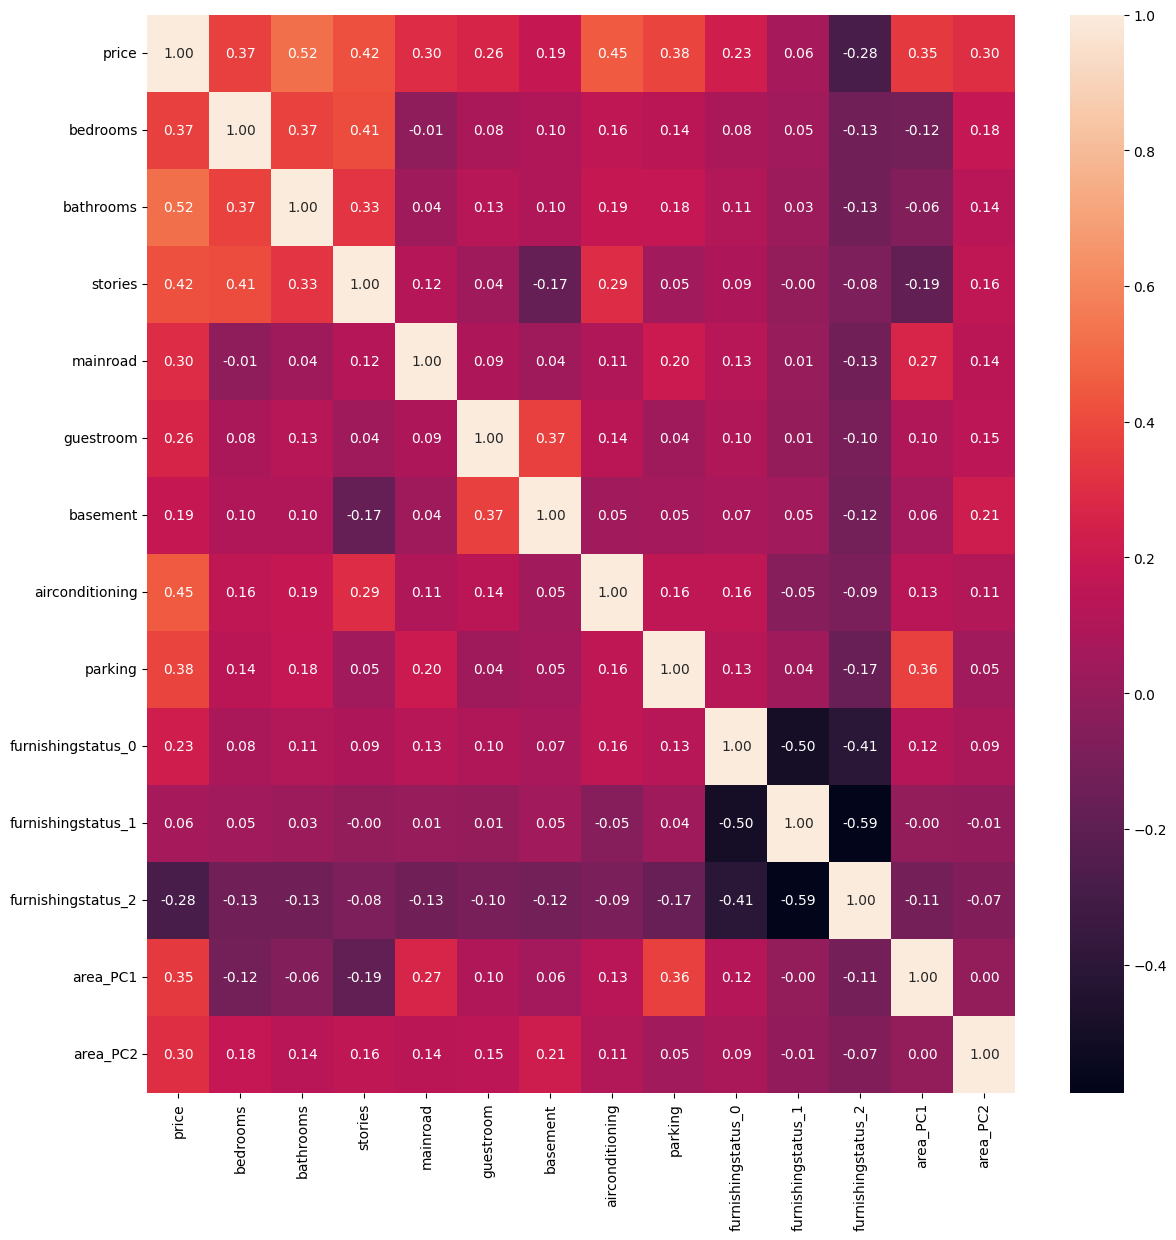

In [915]:
#displays a correlation heatmap 
plt.figure(figsize=(14,14))
sns.heatmap(df.corr(), annot = True, fmt = '.2f')
plt.show()

- According to the heatmap there are no multicollinear columns

In [916]:
#predictor columns are all the columns from the dataframe besides price
x = df.drop('price', axis = 1)
#target variable for machine learning is price
y = df['price']
#create a 70/30 split to create a testing and training subset 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, random_state=7, shuffle=True)
print('shape of predictors for training:', x_train.shape)
print('Shape of target variable for training:', y_train.shape)
print('Shape of predictors for testing:', x_test.shape)
print('Shape of target variable for testing:', y_test.shape)

shape of predictors for training: (381, 13)
Shape of target variable for training: (381,)
Shape of predictors for testing: (164, 13)
Shape of target variable for testing: (164,)


In [917]:
#standardize the predictor columns before machine learning to prevent biases in the machine learning algorithm 
train_scaler = StandardScaler()
test_scaler = StandardScaler()
#ensure that training and testing are standardized separately to prevent data leakage
x_train_scaled = pd.DataFrame(train_scaler.fit_transform(x_train), columns = x_train.columns)
x_test_scaled = pd.DataFrame(test_scaler.fit_transform(x_test), columns=x_test.columns)

In [918]:
x_train_scaled

,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,furnishingstatus_0,furnishingstatus_1,furnishingstatus_2,area_PC1,area_PC2
0,0.003632,-0.573002,0.208748,0.41510,2.089545,-0.749317,1.422607,0.329057,-0.580381,1.168957,-0.694615,0.367278,-0.527233
1,-1.380058,-0.573002,-0.927437,-2.40906,-0.478573,-0.749317,-0.702935,-0.800409,1.723006,-0.855464,-0.694615,0.013082,-0.733290
2,0.003632,1.342031,2.481118,0.41510,-0.478573,-0.749317,1.422607,-0.800409,1.723006,-0.855464,-0.694615,-0.092875,1.875955
3,0.003632,1.342031,0.208748,-2.40906,-0.478573,1.334549,1.422607,-0.800409,-0.580381,1.168957,-0.694615,-0.703049,-0.392918
4,-1.380058,-0.573002,0.208748,0.41510,2.089545,1.334549,-0.702935,-0.800409,-0.580381,-0.855464,1.439646,-0.244843,1.811584
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0.003632,-0.573002,-0.927437,0.41510,-0.478573,-0.749317,-0.702935,1.458522,1.723006,-0.855464,-0.694615,3.848833,-1.712454
377,-1.380058,-0.573002,-0.927437,0.41510,-0.478573,-0.749317,-0.702935,0.329057,-0.580381,1.168957,-0.694615,-0.258766,-0.494796
378,0.003632,-0.573002,0.208748,0.41510,-0.478573,-0.749317,-0.702935,-0.800409,-0.580381,-0.855464,1.439646,-1.516488,-0.167188
379,0.003632,-0.573002,-0.927437,0.41510,2.089545,1.334549,-0.702935,-0.800409,-0.580381,1.168957,-0.694615,1.172317,-1.079218


In [919]:
x_test_scaled

,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,furnishingstatus_0,furnishingstatus_1,furnishingstatus_2,area_PC1,area_PC2
0,-1.163430,-0.568815,-0.935729,0.383214,-0.434057,-0.700649,-0.624364,-0.823492,-0.605530,-0.820652,1.427248,-0.439239,-0.547928
1,0.143437,1.652273,0.263174,0.383214,-0.434057,1.427248,1.601630,-0.823492,-0.605530,1.218544,-0.700649,-0.729195,2.055279
2,-1.163430,-0.568815,-0.935729,0.383214,-0.434057,-0.700649,1.601630,-0.823492,-0.605530,-0.820652,1.427248,-0.656404,-0.473727
3,1.450303,1.652273,0.263174,0.383214,-0.434057,-0.700649,-0.624364,-0.823492,-0.605530,1.218544,-0.700649,-1.188135,-0.210621
4,-1.163430,-0.568815,0.263174,0.383214,-0.434057,-0.700649,-0.624364,-0.823492,-0.605530,-0.820652,1.427248,-0.090407,-0.622847
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,-1.163430,-0.568815,-0.935729,0.383214,-0.434057,-0.700649,-0.624364,-0.823492,-0.605530,-0.820652,1.427248,-0.049840,-0.680979
160,0.143437,1.652273,-0.935729,0.383214,-0.434057,1.427248,-0.624364,-0.823492,-0.605530,1.218544,-0.700649,-0.107235,-0.602667
161,0.143437,1.652273,2.660978,0.383214,2.303843,-0.700649,1.601630,0.426996,1.651446,-0.820652,-0.700649,-0.001857,-0.303631
162,0.143437,-0.568815,-0.935729,0.383214,-0.434057,-0.700649,-0.624364,1.677484,-0.605530,1.218544,-0.700649,0.833290,1.614819


In [920]:
#these are the parameters for each machine learning algorithm when performing grid search for hyperparameter tuning
lr_params = {'fit_intercept':[True, False]}
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100], 'fit_intercept': [True, False]}
knn_params = {'n_neighbors':[2,4,8,16], 'p': [2,3]}
svm_params = {'C': [0.001, 0.01, 0.5, 1, 5,10,15,50,100, 10000]}
lasso_params = {'alpha': [0.1, 1, 10,15,20,50,100]}
rf_params = {'n_estimators':[120, 300, 500], 'max_depth': [5, 8 , 15] , 'min_samples_split': [2,5,10], 'min_samples_leaf':[1,2,5]}
xg_params = {'eta': [0.01, 0.1], 'gamma': [0.05, 0.7], 'max_depth': [3,5,7,9], 'min_child_weight':[1,3,5], 'lambda': [0.01, 0.03,1 ], 
             'alpha': [0, 0.1, 0.5, 1,5, 10,15]}

In [921]:
#performs grid search on machine learning model, returns the model with the best parameters along with its rmse and r2 scores
def perform_grid_search(estimator, param_grid):
    #use grid search that performs cross validation with 5 folds where the performance metric is negative root mean squared error
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, scoring = 'neg_root_mean_squared_error')
    #perform grid search using training data
    grid_search.fit(x_train_scaled, y_train)
    #extract the best performing model from grid search
    best_model = grid_search.best_estimator_
    #make predictions using training data
    y_pred_train = best_model.predict(x_train_scaled)
    #calculate rmse and r2 square of the model using training data
    train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3)
    train_r_square = round(r2_score(y_train, y_pred_train),3)
    print('Best parameters:', grid_search.best_params_)
    print('Root Mean Squared Error for training:', train_rmse)
    print('r2 score for training:', train_r_square)
    return best_model, train_rmse, train_r_square


In [922]:
#create a list where all the best performing hyperparameters for each ml model will be appended 
model_list = []

In [923]:
#extract the best linear regression model, append it to the model list and added performance metrics to dictionary
lr_model, train_lr_rmse, train_lr_r_square = perform_grid_search(LinearRegression(), param_grid=lr_params)
model_list.append(lr_model)
model_train_performance_dict = {}
model_train_performance_dict['Linear Regression'] = [train_lr_r_square, train_lr_rmse]

Best parameters: {'fit_intercept': True}
Root Mean Squared Error for training: 996232.762
r2 score for training: 0.689


In [924]:
#creates a function that displays the coefficient for each column and then a barplot of them in descending based on absolute value of coefficient
def plot_regression_coef(reg_model):
    #create dataframe that displays the feature and its coefficient 
    reg_df = pd.Series(reg_model.coef_, index=reg_model.feature_names_in_).reset_index(name = 'coefficients')
    #rename the index to column to feature
    reg_df.rename(columns = {'index': 'Feature'},inplace=True)
    #sort by absolute value of coefficients
    reg_df = reg_df.sort_values(by = 'coefficients', key = abs, ascending=False)
    #displays a barplot of feature as y and coefficents as x
    sns.barplot(data = reg_df, y = 'Feature', x = 'coefficients')
    #displays dataframe of feature name and its coefficient
    print(reg_df)



               Feature  coefficients
9   furnishingstatus_1  3.033163e+19
10  furnishingstatus_2  2.877060e+19
8   furnishingstatus_0  2.665812e+19
11            area_PC1  6.527399e+05
1            bathrooms  6.307510e+05
6      airconditioning  4.164964e+05
2              stories  3.945826e+05
0             bedrooms  2.143545e+05
3             mainroad  1.973070e+05
12            area_PC2  1.713396e+05
5             basement  1.576023e+05
4            guestroom  1.423513e+05
7              parking  1.239411e+05


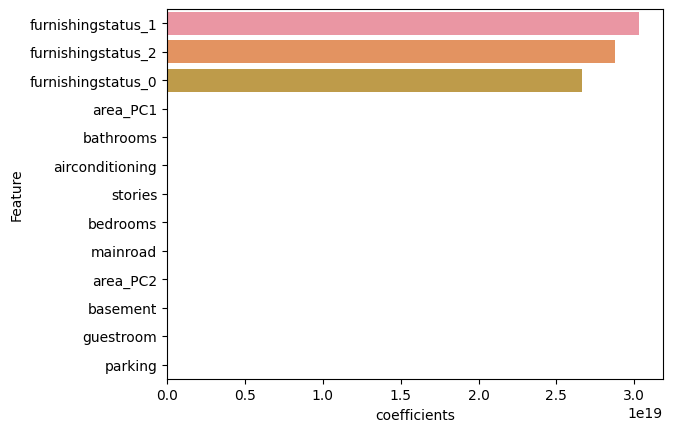

In [925]:
#displays coefficient per feature and plot of it for linear regression
plot_regression_coef(lr_model)

The furnishing status coefficients are at a higher magnitude than the rest of the columns
- This could lead to extreme overfitting

In [926]:
#extract the best ridge regression model, append it to the model list and added performance metrics to dictionary
ridge_model, train_ridge_rmse, train_ridge_r_square = perform_grid_search(Ridge(), param_grid=ridge_params)
model_list.append(ridge_model)
model_train_performance_dict['Ridge Regression'] = [train_ridge_r_square, train_ridge_rmse]

Best parameters: {'alpha': 10, 'fit_intercept': True}
Root Mean Squared Error for training: 996551.428
r2 score for training: 0.689


               Feature   coefficients
11            area_PC1  628485.471564
1            bathrooms  618224.040749
6      airconditioning  404438.765616
2              stories  392875.269978
0             bedrooms  200765.778352
3             mainroad  196410.986412
12            area_PC2  170278.807057
5             basement  151770.517552
4            guestroom  135214.095861
7              parking  124762.696556
10  furnishingstatus_2  -74495.942910
9   furnishingstatus_1   43617.234066
8   furnishingstatus_0   30771.523132


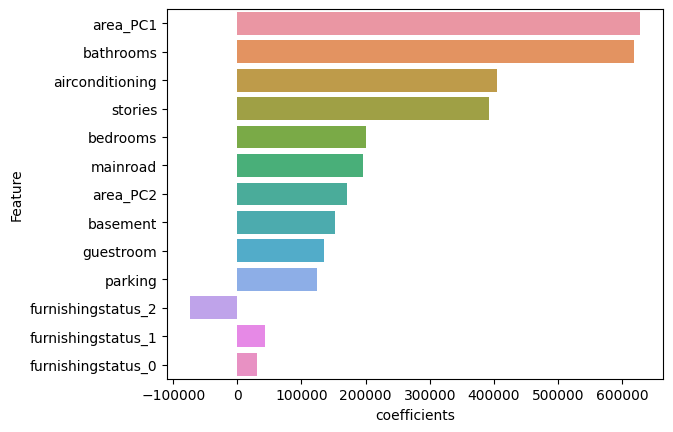

In [927]:
#displays coefficient per feature and plot of it for ridge regression
plot_regression_coef(ridge_model)

The furnishing status coefficients were severely penalized in comparison to the linear regression coefficients 
- this could help prevent some over fitting when testing on the model on the test subset


In [928]:
#extract the best knn model, append it to the model list and added performance metrics to dictionary
knn_model, train_knn_rmse, train_knn_r_square = perform_grid_search(KNeighborsRegressor(), param_grid=knn_params)
model_list.append(knn_model)
model_train_performance_dict['K-Nearest Neighbors'] = [train_knn_r_square, train_knn_rmse]

Best parameters: {'n_neighbors': 8, 'p': 2}
Root Mean Squared Error for training: 1018446.987
r2 score for training: 0.675


In [929]:
#plots shapley values for feature importance of machine learning algorithm
def plot_shap_train(model, data_subset):
    explainer = shap.Explainer(model.predict, data_subset)
    shap_values = explainer(data_subset)
    shap_values_matrix = np.array(shap_values.values)
    shap.summary_plot(shap_values_matrix, data_subset, plot_type='dot')


PermutationExplainer explainer: 382it [00:46,  6.52it/s]                         


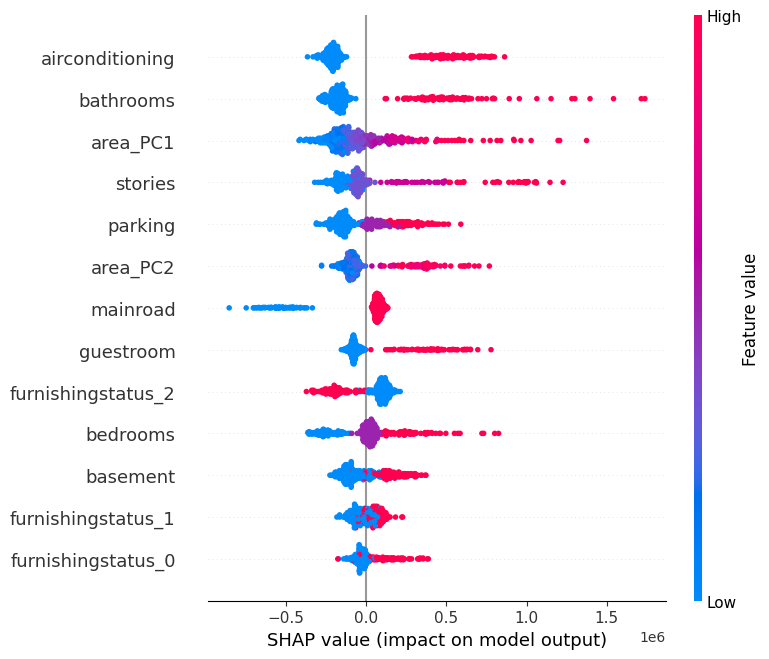

In [930]:
#displays feature importance plot for knn
plot_shap_train(knn_model, x_train_scaled)

In [931]:
label_encoder.classes_

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

for knn feature importance via SHAP values:
- houses with air conditioning are higher in pirce, while unpresent airconditioning are lower in house price
- Houses with higher in number of bathrooms lead are high in price, low number of bathrooms lead have houses that are lower in price
- houses high area_pc1, area_pc2, have a guestroom, a mainroad close, unfurnished or furnished have a higher house price, low values or unpresent values of those columns have lower house prices
- medium amount of stories have slightly low prices, higher stories have high house prices, and lower stories have lower pricing
-  medium amount of parking have slightly  high prices, higher parking have high house prices, and lower parking have lower pricing
- semi-furnishing status values are mixed

In [932]:
#extract the best svm model, append it to the model list and added performance metrics to dictionary
svm_model, train_svm_rmse, train_svm_r_square = perform_grid_search(SVR(), param_grid=svm_params)
model_list.append(svm_model)
model_train_performance_dict['SVM'] = [train_svm_r_square, train_svm_rmse]

Best parameters: {'C': 10000}
Root Mean Squared Error for training: 1720168.695
r2 score for training: 0.074


PermutationExplainer explainer: 382it [07:32,  1.25s/it]                         


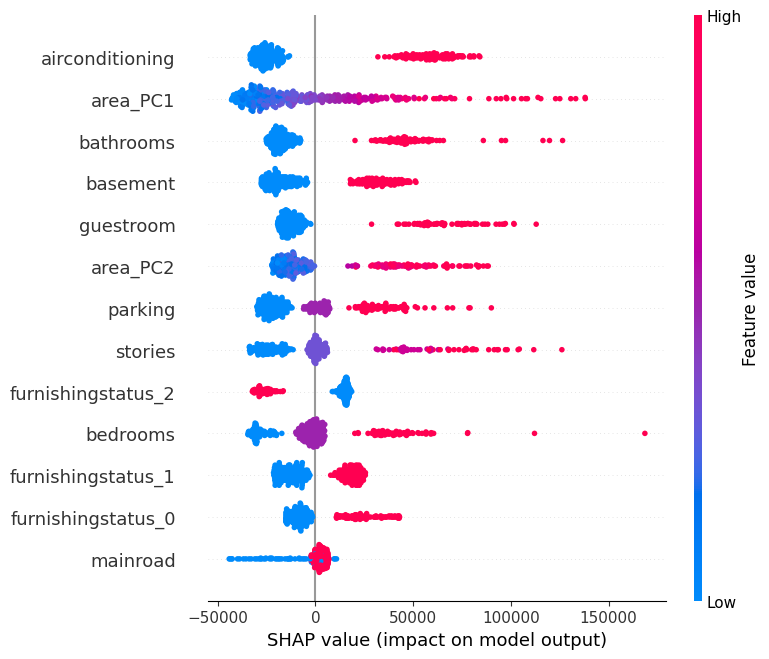

In [933]:
#displays feature importance plot for svm
plot_shap_train(svm_model, x_train_scaled)

Feature importance based on Shap for SVM:
- airconditioning present houses are higher in price, non aircondition houses are lower in price
- high area_pc1 = high house price, low area_pc1 = low house price, medium area_pc1 = mixed
- high bathrooms = high house price, low bathrooms = low house price
- basement = high house price, no basement = low house price
- guestroom present = high house price, guestroom not present = low house price
- high parking = high house price, medium parking = no impact, low parking = low price
- high stories = high house price, medium stories = no impact, low stories = low price
- high bedrooms = high house price, medium bedrooms = no impact, low bedrooms = low price
- 


In [934]:
#extract the best lasso regression model, append it to the model list and added performance metrics to dictionary
lasso_model, train_lasso_rmse, train_lasso_r_square = perform_grid_search(Lasso(), param_grid=lasso_params)
model_list.append(lasso_model)
model_train_performance_dict['Lasso Regression'] = [train_lasso_r_square, train_lasso_rmse]

Best parameters: {'alpha': 100}
Root Mean Squared Error for training: 996168.092
r2 score for training: 0.689


               Feature   coefficients
11            area_PC1  651414.062942
1            bathrooms  634173.850859
6      airconditioning  408740.153063
2              stories  402906.348942
0             bedrooms  198836.143980
3             mainroad  196159.463584
12            area_PC2  171565.579821
5             basement  156659.015689
4            guestroom  133092.968998
7              parking  116325.091431
10  furnishingstatus_2 -101870.518216
9   furnishingstatus_1   13918.561047
8   furnishingstatus_0       0.000000


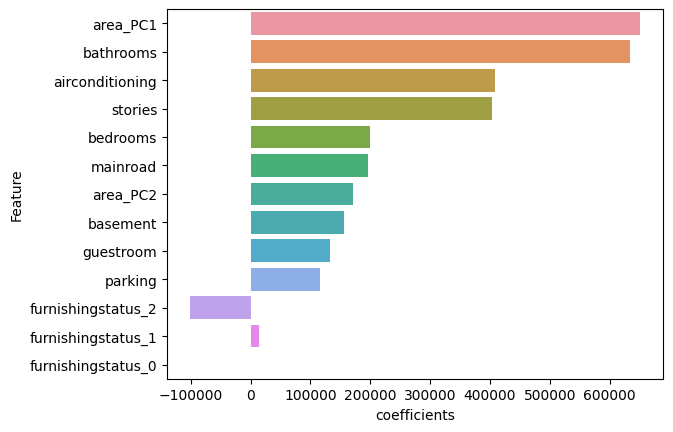

In [935]:
#displays coefficient per feature and plot of it for ridge regression
plot_regression_coef(lasso_model)

Coefficients for lasso:
- furnishing status was penalized severely, furnishingstatus_0 was set to zero, show that it has no impact in terms of lasso

In [936]:
#extract the best random forest model, append it to the model list and added performance metrics to dictionary
rf_model, train_rf_rmse, train_rf_r_square = perform_grid_search(RandomForestRegressor(random_state=7), param_grid=rf_params)
model_list.append(rf_model)
model_train_performance_dict['Random Forest'] = [train_rf_r_square, train_rf_rmse]

Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Root Mean Squared Error for training: 669765.772
r2 score for training: 0.86


In [937]:
#displays feature importance for tree ensemble models as barplot
def tree_feature_importance(tree_model):
    #creates a dataframe for feature and its feature importanace value sorted in descending order
    tree_model_df = pd.Series(tree_model.feature_importances_, index = x_train_scaled.columns).reset_index(name = 'importance').sort_values(by = 'importance', ascending=False)
    tree_model_df.rename(columns = {'index': 'feature'}, inplace = True)
    #plot barplot where feature is y and the importance values the x axis 
    sns.barplot(data = tree_model_df, x = 'importance', y = 'feature')


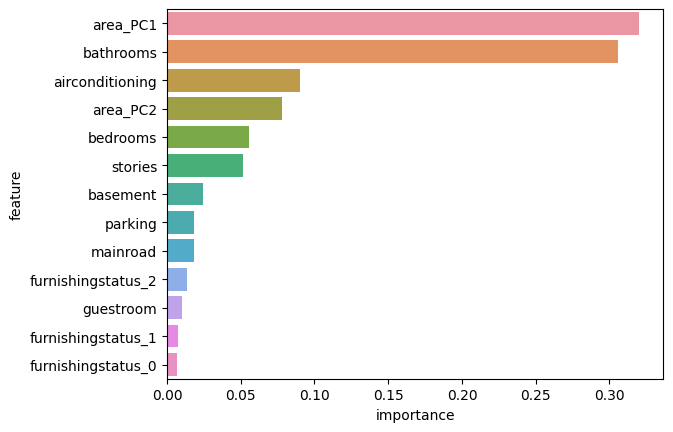

In [938]:
#display feature importance for random forest model 
tree_feature_importance(tree_model=rf_model)

random forest feature importance:
- area_pc1 and bathrooms were the most important
- furnishingstatus1 and 0 were the least important

In [939]:
#extract the best xgboost model, append it to the model list and added performance metrics to dictionary
xg_model, train_xg_rmse, train_xg_r_square = perform_grid_search(XGBRegressor(random_state = 7), param_grid=xg_params)
model_list.append(xg_model)
model_train_performance_dict['XGBoost'] = [train_xg_r_square, train_xg_rmse]

Best parameters: {'alpha': 15, 'eta': 0.1, 'gamma': 0.05, 'lambda': 1, 'max_depth': 3, 'min_child_weight': 5}
Root Mean Squared Error for training: 651900.987
r2 score for training: 0.867


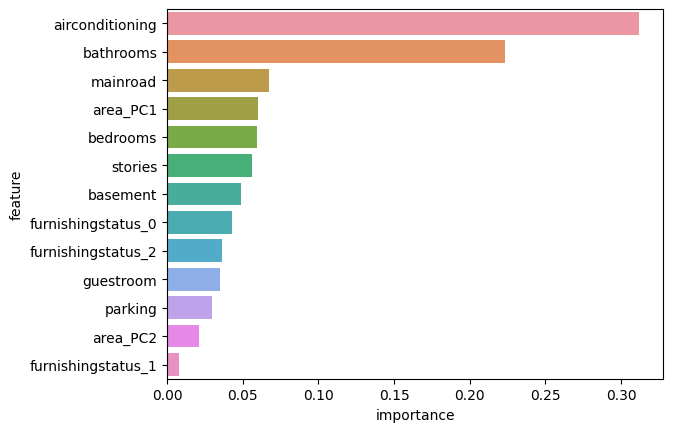

In [940]:
#display feature importance for random forest model 
tree_feature_importance(xg_model)

xgboost feature importance:
- airconditioning and bathrooms were the most important 
- furnishing status 1 and area pc_2 were the least important

In [941]:
#convert the model performance dictionary into a dataframe 
model_train_performance_df = pd.DataFrame(model_train_performance_dict).T.reset_index()
model_train_performance_df.rename(columns = {'index':'Model', 0:'r_square', 1:'rmse'}, inplace=True)


In [942]:
#create a barplot with labels on the bars
def plot_barplot(data, x, y,size):
    plt.figure(figsize=size)
    #display barplot
    ax = sns.barplot(data=data,x=x,y=y)
    #add bar labels to barplot
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

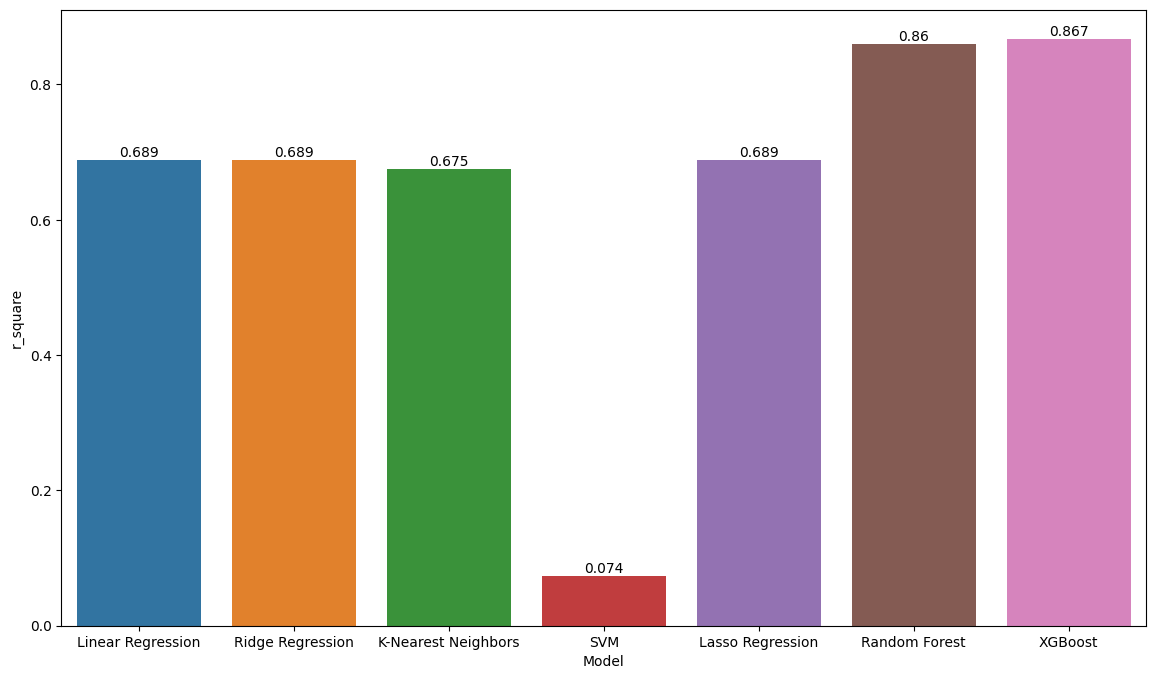

In [943]:
#displays a barplot that shows the r2 of each model 
plot_barplot(model_train_performance_df, x = 'Model', y = 'r_square', size = (14,8))

- XGBoost was the best performing model in terms of r2 followed by random forest
- The worst performance by a large marigin in comparison to the rest for r2 was SVM

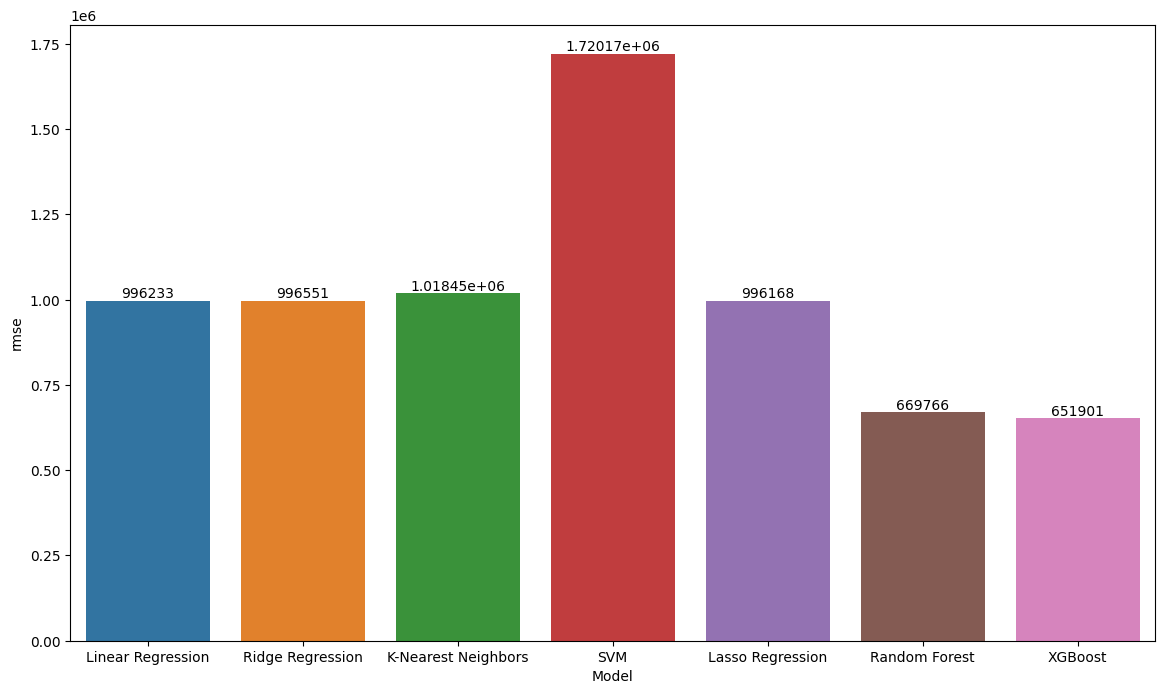

In [944]:
#displays a barplot that shows the rmse of each model 
plot_barplot(model_train_performance_df, x= 'Model', y = 'rmse', size = (14,8))

- top 2 best performing was xgboost and random forest for rmse
- worst performing was svm for rmse

In [945]:
#create a dictionary to add rmse and r2 for each model when using the testing subset
model_test_dict = {}
#create function that gets the r2 and rmse score using the testing subset for each machine learning model 
def get_test_rmse_and_r_square(model):
    #get the predicted target values using testing
    y_pred = model.predict(x_test_scaled)
    #calculate and return rmse and r2 score as a list
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
    r_square = round(r2_score(y_test, y_pred),3)
    return [r_square, rmse]

In [946]:
#using the function to retrieve rmse and r2 scores using testing subset, add the scores to the dictionary for each model 
model_test_dict['Linear Regression'] = get_test_rmse_and_r_square(lr_model)
model_test_dict['Ridge Regression'] = get_test_rmse_and_r_square(ridge_model)
model_test_dict['K-Nearest Neighbors'] = get_test_rmse_and_r_square(knn_model)
model_test_dict['SVM'] = get_test_rmse_and_r_square(svm_model)
model_test_dict['Lasso Regression'] = get_test_rmse_and_r_square(lasso_model)
model_test_dict['Random Forest'] = get_test_rmse_and_r_square(rf_model)
model_test_dict['XGBoost'] = get_test_rmse_and_r_square(xg_model)

In [947]:
#convert model performance rmse and r2 scores for each ml model into a dictionary and transpose to transform dictionary keys into a single column value in a dataframe
model_test_performance_df = pd.DataFrame(model_test_dict).T.reset_index()
model_test_performance_df.rename(columns = {'index':'Model', 0:'r_square', 1:'rmse'}, inplace=True)

In [948]:
model_test_performance_df

,Model,r_square,rmse
0,Linear Regression,-1.094322e+23,6.765092e+17
1,Ridge Regression,6.190000e-01,1.261590e+06
2,K-Nearest Neighbors,6.020000e-01,1.290565e+06
3,SVM,7.300000e-02,1.968700e+06
4,Lasso Regression,6.180000e-01,1.264743e+06
5,Random Forest,5.650000e-01,1.349481e+06
6,XGBoost,4.270000e-01,1.548015e+06


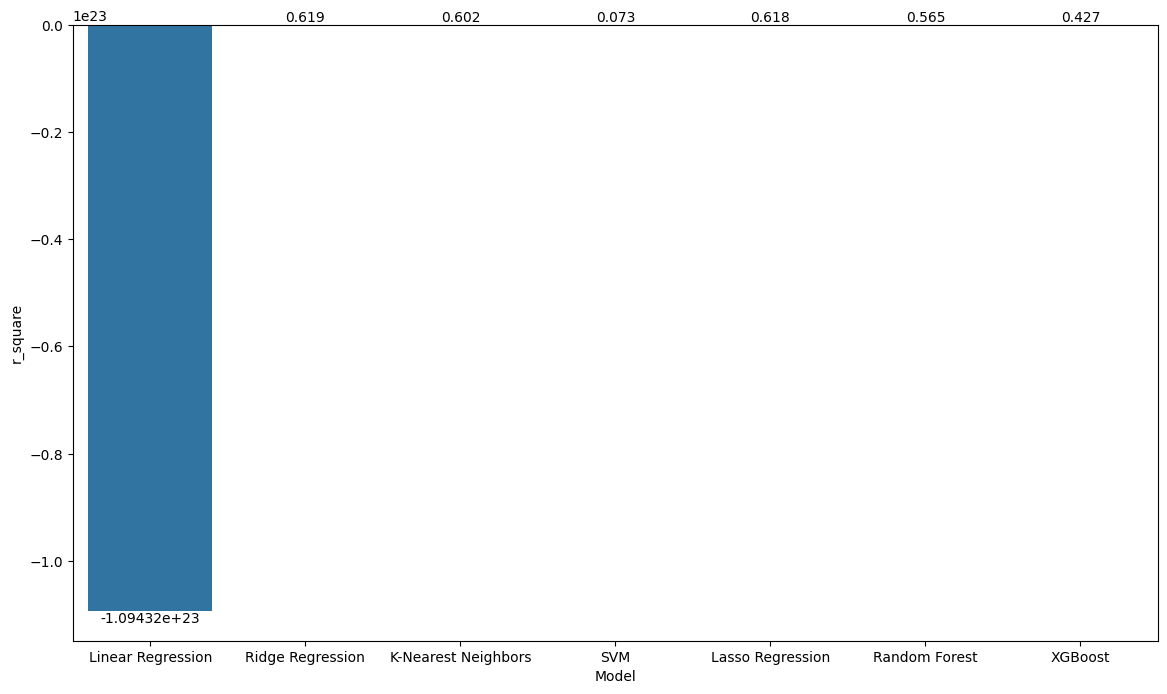

In [949]:
#displays r2 score of each model as a bar graph
plot_barplot(data = model_test_performance_df, x= 'Model', y = 'r_square', size = (14,8))

- Linear regression overfitted significantly compared to the rest of the models for r2

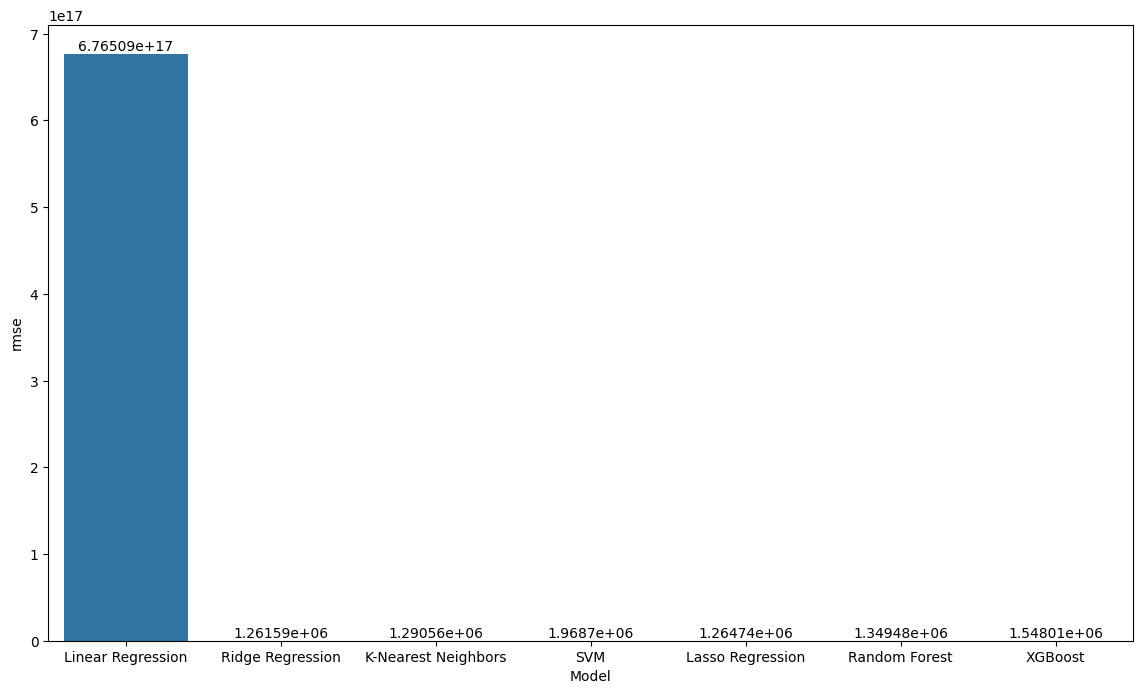

In [950]:
#displays rmse score of each model as a bar graph
plot_barplot(data = model_test_performance_df, x= 'Model', y = 'rmse', size = (14,8))

Linear regression overfitted significantly compared to the rest of the models for rmse
- When the r2 is a negative number, it means that the predictions made by the model signficantly worse than using the mean of price
- residuals have an extremely high variance

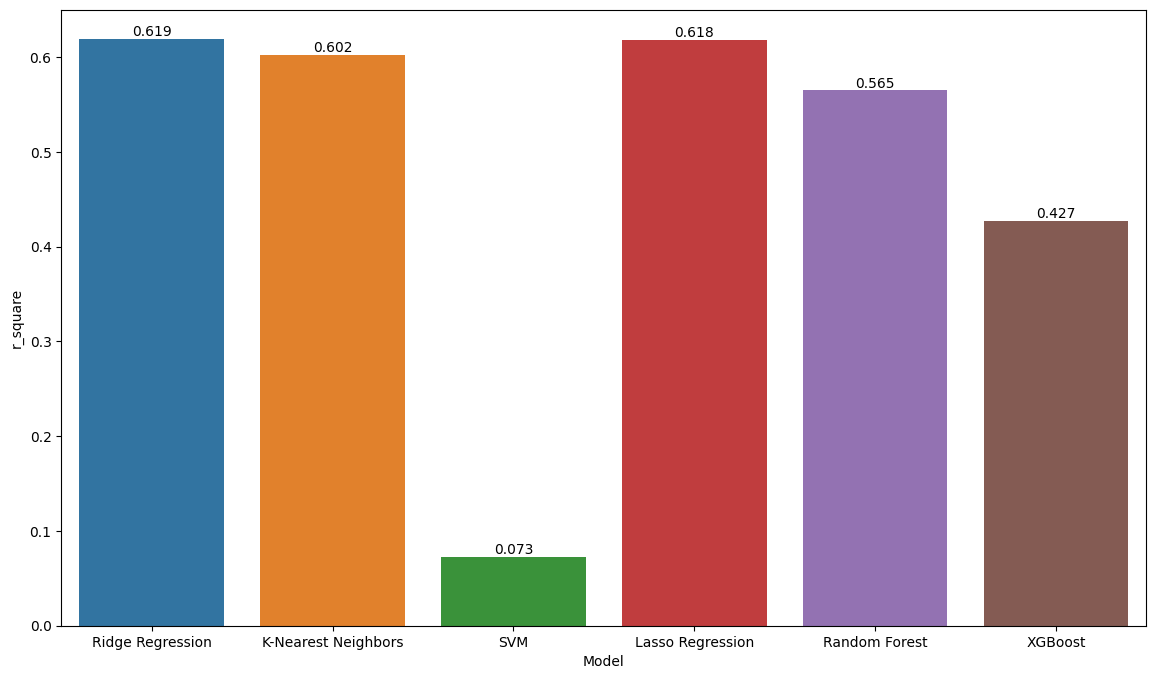

In [951]:
#displays r2 score of each model as a bar graph but filters out linear regression model 
plot_barplot(data = model_test_performance_df.loc[model_test_performance_df['Model']!='Linear Regression'], x= 'Model', y = 'r_square', size = (14,8))

- ridge, lasso and knn overfitted the least when testing the data using testing for r2
- svm was the worst performing besides linear regression, however it did not overfit that much
- Ridge was the best model by a small marigin in terms of r2

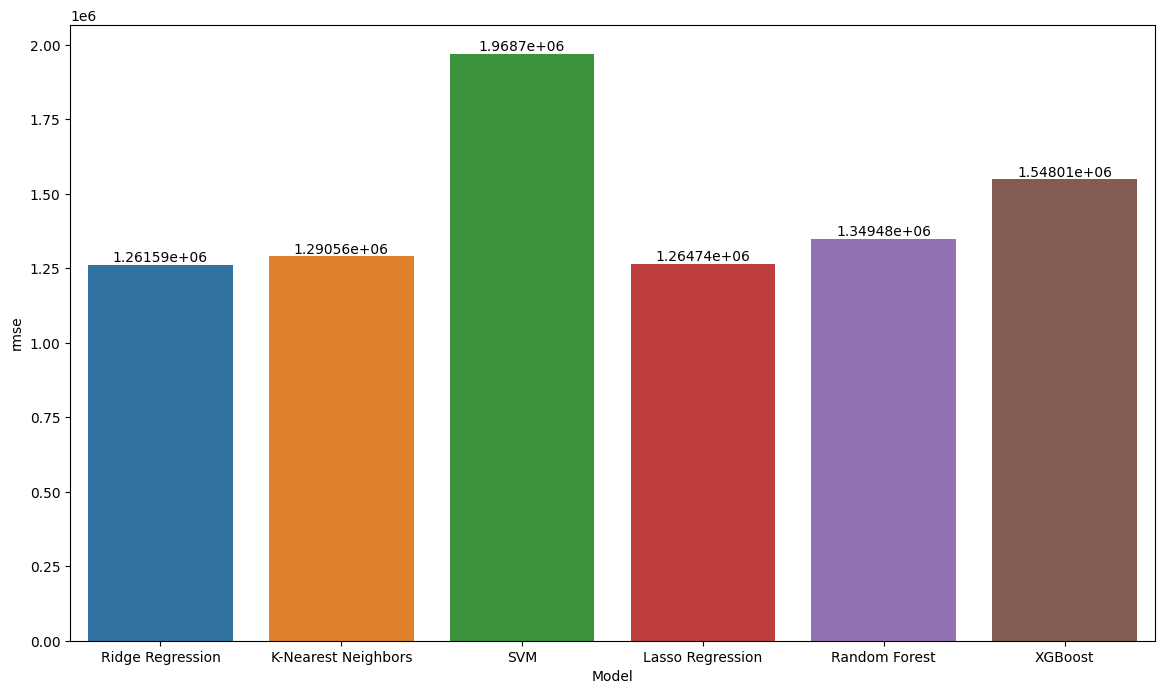

In [952]:
#displays rmse score of each model as a bar graph but filters out linear regression model 
plot_barplot(data = model_test_performance_df.loc[model_test_performance_df['Model']!='Linear Regression'], x= 'Model', y = 'rmse', size = (14,8))

- ridge regression was best performing model in terms of rmse 
- svm was the worst performing model besides linear regression

Overall, the model that I suggest to use to predict housing prices is Ridge regression, ot did the best when testing on the training subset.

I expected the ensemble models to be the best performing in terms generalization, but it was not the case for this problem, here are some reasons:
- features were very noisy, which can cause significant overfitting
- the data is really small which can lead to the model overfitting, more data could increase the models' performance. 
- Models are too complex leading it take capture noise instead of signal 
- The noisiness and size of the data maybe the reason why knn even generalizes better than the ensemble models


In [959]:
xgb_model_2 = xg_model
xgb_model_2.fit(x_train_scaled[['airconditioning', 'bathrooms']], y_train)
xgb_model_2_y_pred = xgb_model_2.predict(x_test_scaled[['airconditioning', 'bathrooms']])
print('r2 score:', r2_score(y_test, xgb_model_2_y_pred))

r2 score: 0.3606232031678801


For xgboost, even after only selecting "the most importance features", it generalizes worse. 